In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import numpyro
numpyro.enable_x64(True)
numpyro.set_platform("gpu")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind", 10))
from plotting import *

## Load model
from model import *
## Load data
from data import load_mira_sample
data = load_mira_sample(lowb=True, sig_clip=3., reliable=True, 
                        high_amp=True, per_cut=[100.,1000.], 
                        scale_proper_motion_errors=False)

## Selection function
from selection_function import selection_function
include_selection_function = True
if include_selection_function:
    SF = selection_function(data_file='selection_function.csv')
else:
    SF = None

## Bar model interpolant
from bar_model_interpolant import Portail_interp
import pickle
use_pickle = True
if include_selection_function:
    if use_pickle:
        with open('/data/jls/mira/bar_model_distance_interpolant.pkl', 'rb') as f:
            bar_model = pickle.load(f)
    else:
        bar_model = Portail_interp(N=20, include_distance=True)
        with open('/data/jls/mira/bar_model_distance_interpolant.pkl', 'wb') as f:
            pickle.dump(bar_model, f)
else:
    bar_model = Portail_interp(N=20, include_distance=False)
    
bar_model_nodist = Portail_interp(N=20, include_distance=False)

default_N_knots = 12

reading Portail bar...
finished


# Sormani+ 2022 model -- best f(J) params

/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


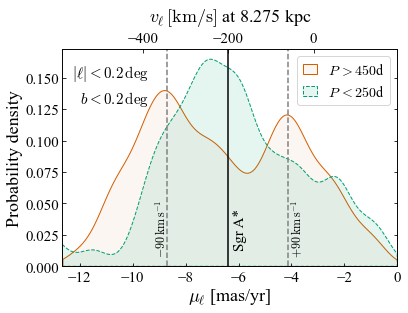

In [2]:
sns.kdeplot(data['pml'][(np.abs(data['l']-360.*(data['l']>180.))<0.2)
&(data['period']>450.)&(np.abs(data['b'])<0.2)
&(np.abs(data['epml'])<7.)]/4.74,bw=0.2,clip=[-60/4.74,0],
color=sns.color_palette('colorblind')[3],label='$P\,>450$d',fill=True,alpha=0.05);

sns.kdeplot(data['pml'][(np.abs(data['l']-360.*(data['l']>180.))<0.2)
&(data['period']<250.)&(np.abs(data['b'])<0.2)
&(np.abs(data['epml'])<7.)]/4.74,bw=0.2,clip=[-60/4.74,0],
color=sns.color_palette('colorblind')[2],label='$P\,<250$d',fill=True,alpha=0.1,ls='dashed');
plt.annotate(r'$|\ell|<0.2\,\mathrm{deg}$',xy=(-12.3,0.15),fontsize=15)
plt.annotate(r'$b<0.2\,\mathrm{deg}$',xy=(-12.,0.13),fontsize=15)
plt.axvline(-6.41,color='k')
plt.axvline(-6.41-90./8.275/4.74,color='gray',ls='--')
plt.axvline(-6.41+90./8.275/4.74,color='gray',ls='--')
plt.xlabel(r'$\mu_\ell$ [mas/yr]')
plt.xlim(-60./4.74,0.)
plt.ylabel('Probability density')
plt.annotate('Sgr A*', (-6.2,0.015),rotation=90,fontsize=15)

plt.gca().tick_params(axis="y",direction="in")
plt.gca().tick_params(axis="x",direction="in")
plt.gca().tick_params(axis="y",direction="in",which='minor')
plt.gca().tick_params(axis="x",direction="in",which='minor')
plt.gca().tick_params(axis='y', which='minor', bottom=False)
plt.gca().yaxis.set_ticks_position('both')
l=plt.legend(loc='upper right',handlelength=1)
# for text in l.get_texts():
#     text.set_color("red")
plt.gca().twiny()
plt.xlim(-15*4.74*8.275,5*4.74*8.275)
plt.xlabel(r'$v_\ell\,[\mathrm{km}/\mathrm{s}]$ at 8.275 kpc', labelpad=10)
plt.annotate(r'$-90\,\mathrm{km\,s}^{-1}$',xy=(-105-6.41*4.74*8.275,0.01),fontsize=12,ha='center',rotation=90)
plt.annotate(r'$+90\,\mathrm{km\,s}^{-1}$',xy=(215-6.41*4.74*8.275,0.01),fontsize=12,ha='center',rotation=90)

plt.gca().tick_params(axis="x",direction="in")
plt.gca().tick_params(axis="x",direction="in",which='minor')

plt.savefig('plots/kinematics_split.pdf',bbox_inches='tight')

Using S22 weights
[5.07879839e-02 1.87795214e-02 1.11941525e+02 3.30594378e-01]


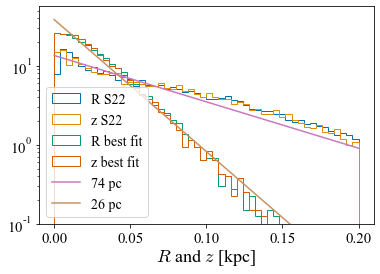

In [3]:
## Run optimization on S22 samples
## ===============================
from df_jax import binney_df_jax_spline, quasiisothermal_df_jax_spline

default_model_coords = make_default_galaxy_model().sample(10000)[0]
default_model_action = default_action_finder(default_model_coords)
default_model_action = jnp.vstack([default_model_action.T, 
                                  find_frequencies(default_model_action, default_galaxy_model.potential).T]).T

aux_params = {'use_s22_weights':True, 'include_background_weight':False, 'df_type':'quasiisothermal'}

from jax.scipy.optimize import minimize
def minimize_logL_bdf(params, aux_params):
    bdf = quasiisothermal_df_jax_spline(params[0],
                               params[1],
                               params[2],
                               params[3],
                               aux_knots=None, 
                               )
    return -jnp.sum(bdf(default_model_action,jnp.ones_like(len(default_model_action))*2.5,log=True))

class simple_min(object):
    def __init__(self,m,ax):
        self.x = m.x
        self.aux_parameters = ax
        self.type='s22'

min_results_s22 = simple_min(minimize(minimize_logL_bdf, 
                       jnp.array([np.log(0.07), np.log(0.03), np.log(50.), np.log(1.)]), 
                       args=(aux_params,),method='BFGS'),aux_params)

samples_map_all_s22=generate_samples(min_results_s22,
                                     Nsamples=10000,
                                     N_emcee_iterations=300)

plt.hist(np.sqrt(default_model_coords[:,0]**2+default_model_coords[:,1]**2),
         bins=50,histtype='step',range=[0,0.2],
         density=True,weights=1./np.sqrt(default_model_coords[:,0]**2+default_model_coords[:,1]**2),
         label='R S22');

AGG = agama_GalactocentricFromGalactic(samples_map_all_s22)
plt.hist(np.sqrt(AGG[:,0]**2+AGG[:,1]**2),
            bins=50,histtype='step',range=[0,0.2],
            density=True,weights=1./np.sqrt(AGG[:,0]**2+AGG[:,1]**2),label='z S22');

plt.hist(np.abs(default_model_coords[:,2]),
         bins=50,histtype='step',range=[0,0.2],
         density=True,label='R best fit');
plt.hist(np.abs(AGG[:,2]),
            bins=50,histtype='step',range=[0,0.2],
            density=True,label='z best fit');


plt.semilogy()
xx = np.linspace(0,0.2,100)
plt.plot(xx, np.exp(-xx/0.074)/0.074,label='74 pc')
plt.plot(xx, np.exp(-xx/0.026)/0.026, label='26 pc')
plt.ylim(0.1,)
plt.xlabel(r'$R$ and $z$ [kpc]')
plt.legend()

print(np.exp(min_results_s22.x))

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 55.84it/s]


Text(0.5, 1.0, '0.3326')

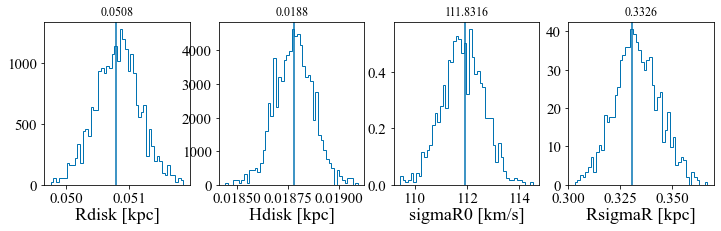

In [4]:
## Check for degeneracies in S22 parameters
def mcmc_logL_bdf(data, params):
    bdf = quasiisothermal_df_jax_spline(params['ln_Rdisk'],
                               params['ln_Hdisk'],
                               params['ln_sigmaR0'],
                               params['ln_RsigmaR'],
                               aux_knots=None, 
                               )
    return bdf(data['action'],jnp.ones_like(len(data['action']))*2.5,log=True)

parameters = {'ln_Rdisk':  numpyro.distributions.Normal(loc=jnp.log(0.07),scale=1.), 
                    'ln_Hdisk':  numpyro.distributions.Normal(loc=jnp.log(0.03),scale=1.),
                    'ln_sigmaR0': numpyro.distributions.Normal(loc=jnp.log(100.),scale=1.),
                    'ln_RsigmaR': numpyro.distributions.Normal(loc=3.,scale=1.),
                    }
model = numpyro_model(mcmc_logL_bdf, parameters, {'action':default_model_action})
model.run_mcmc(num_warmup=300, num_samples=300, num_chains=4)

f,a=plt.subplots(1,4,figsize=(12,3))
plt.sca(a[0])
plt.hist(np.exp(np.array(model.samples()['ln_Rdisk'])), bins=50, histtype='step', density=True, label='Rdisk');
plt.title('%0.4f'%np.nanmedian(np.exp(np.array(model.samples()['ln_Rdisk']))))
plt.axvline(np.exp(min_results_s22.x[0]))
plt.xlabel('Rdisk [kpc]')
plt.sca(a[1])
plt.hist(np.exp(np.array(model.samples()['ln_Hdisk'])), bins=50, histtype='step', density=True, label='Hdisk');
plt.axvline(np.exp(min_results_s22.x[1]))
plt.title('%0.4f'%np.nanmedian(np.exp(np.array(model.samples()['ln_Hdisk']))))
plt.xlabel('Hdisk [kpc]')
plt.sca(a[2])
plt.hist(np.exp(np.array(model.samples()['ln_sigmaR0'])), bins=50, histtype='step', density=True, label='sigmaR0');
plt.axvline(np.exp(min_results_s22.x[2]))
plt.title('%0.4f'%np.nanmedian(np.exp(np.array(model.samples()['ln_sigmaR0']))))
plt.xlabel('sigmaR0 [km/s]')
plt.sca(a[3])
plt.hist(np.exp(np.array(model.samples()['ln_RsigmaR'])), bins=50, histtype='step', density=True, label='RsigmaR');
plt.axvline(np.exp(min_results_s22.x[3]))
plt.xlabel('RsigmaR [kpc]')
plt.title('%0.4f'%np.nanmedian(np.exp(np.array(model.samples()['ln_RsigmaR']))))

# Generating numerator and denominator samples 

In [5]:
n_d_samples_noSF = generate_numerator_and_denominator_samples(data, bar_model_nodist, 
                                                         N_num_samples=500, 
                                                         N_denom_samples=1000, 
                                                         SF=None,
                                                         include_radial_velocities=False,
                                                         include_pml=True)

In [6]:
n_d_samples = generate_numerator_and_denominator_samples(data, bar_model, 
                                                         N_num_samples=500, 
                                                         N_denom_samples=1000, 
                                                         SF=SF,
                                                         include_radial_velocities=False,
                                                         include_pml=True)

In [7]:
## Optimization function
## =====================

from typing import Any
from jax.scipy.optimize import minimize

def knots(Nknots, knot_spacing):

    if knot_spacing=='linear':
        spacing = 1./(Nknots-3)
        return jnp.linspace(2.-spacing,3.+spacing,Nknots)
    elif knot_spacing=='percentile':
        return jnp.percentile(data['period'].values, jnp.linspace(0.,100.,Nknots+2))[1:-1]
    elif knot_spacing=='age':
        return np.log10(period_age(jnp.linspace(0.2,12.,Nknots)))

class minimization_results:
    def __init__(self, m, aux):
        self.x = m.x
        self.min=m
        self.aux_parameters = aux
        self.type='minimization'


def run_optimization_no_spline(n_d_samples, min_period, max_period, include_background_weight, 
                               use_s22_weights, background_model='p17', df_type='quasiisothermal'):
    """
    Run optimization for a given period range, with or without the Portail weight, and with or without the S22 weights.
    Not using spline for the DF.

    Parameters
    ----------
    n_d_samples : dict
        Dictionary of numerator and denominator samples.
    min_period : float
        Minimum period to include in the optimization.
    max_period : float
        Maximum period to include in the optimization.
    include_background_weight : bool
        Whether to include the background weight in the optimization.
    background_model : str
        Which background model to use. Either 'p17' or 'dd' for Portail+17 and data-driven respectively.
    use_s22_weights : bool
        Whether to use the S22 weights in the optimization.
    df_type : str
        Type of DF to use. Either 'quasiisothermal' or 'binney'.

    Returns
    -------
    min_results : dict
        Dictionary of the results of the optimization.
    """

    aux_params = {'include_background_weight':include_background_weight, 
                  'df_type': df_type, 
                  'use_s22_weights': use_s22_weights,
                  'background_model': background_model}

    fltr = (n_d_samples['denom_log10P'][:,0]>np.log10(min_period))&(n_d_samples['denom_log10P'][:,0]<np.log10(max_period))
    n_d_samples_fltr = {k: n_d_samples[k][fltr] for k in n_d_samples.keys()}

    prior_std_widths = jnp.array([0.3,0.3,0.3,0.3])

    def minimize_logL_numpyro(params, aux_params):

        params_S = {'ln_Rdisk':params[0],
                    'ln_Hdisk':params[1],
                    'ln_sigmaR0':params[2],
                    'ln_RsigmaR':params[3]}
        
        if aux_params['include_background_weight']:
            if aux_params['use_s22_weights']:
                params_S = {'ln_w_P': params[0]}
            else:
                params_S['ln_w_P'] = params[4]

        if not aux_params['use_s22_weights']:
            prior = jnp.sum(-(params[:4]-min_results_s22.x[:4])**2/2./prior_std_widths**2)
        else:
            prior = 0.
        
        return -jnp.sum(logL_numpyro(n_d_samples_fltr, params_S, 
                                     use_s22_weights=aux_params['use_s22_weights'], 
                                     df_type=aux_params['df_type'],
                                     include_background_weight=aux_params['include_background_weight'],
                                     aux_knots=None,
                                     background_model=aux_params['background_model']))-prior

    def init_guess(aux_params):
        if aux_params['include_background_weight']:
            if aux_params['use_s22_weights']:
                return jnp.zeros(1)
            else:
                return jnp.concatenate([jnp.array(min_results_s22.x),jnp.zeros(1)])
        else:
            return jnp.array(min_results_s22.x)

    min_results = minimize(minimize_logL_numpyro, init_guess(aux_params), 
                        args=(aux_params,),method='BFGS')
    
    return minimization_results(min_results, aux_params)

def run_optimization_spline(n_d_samples, 
                            Nknots,
                            include_background_weight, 
                            use_s22_weights,
                            background_model='p17', 
                            knot_spacing='linear', 
                            df_type='quasiisothermal'):
    """
    Run optimization for a given period range, with or without the Portail weight, and with or without the S22 weights.
    Not using spline for the DF.

    Parameters
    ----------
    n_d_samples : dict
        Dictionary of numerator and denominator samples.
    min_period : float
        Minimum period to include in the optimization.
    max_period : float
        Maximum period to include in the optimization.
    include_background_weight : bool
        Whether to include the background weight in the optimization.
    background_model : str
        Which background model to use. Either 'p17' or 'dd' for Portail+17 and data-driven respectively.
    use_s22_weights : bool
        Whether to use the S22 weights in the optimization.
    df_type : str
        Type of DF to use. Either 'quasiisothermal' or 'binney'.

    Returns
    -------
    min_results : dict
        Dictionary of the results of the optimization.
    """

    aux_params = {'include_background_weight':include_background_weight, 
                  'df_type': df_type, 
                  'use_s22_weights': use_s22_weights,
                  'background_model': background_model}
                  
    aux_params['aux_knots'] = knots(Nknots, knot_spacing)

    prior_std_widths = jnp.array([0.3,0.3,0.3,0.3])

    def minimize_logL_numpyro(params, aux_params):

        params_S = {'ln_Rdisk':params[:Nknots],
                    'ln_Hdisk':params[Nknots:2*Nknots],
                    'ln_sigmaR0':params[2*Nknots:3*Nknots],
                    'ln_RsigmaR':params[3*Nknots:4*Nknots]}

        if aux_params['include_background_weight']:
            if aux_params['use_s22_weights']:
                params_S = {'ln_w_P': params[:Nknots]}
            else:
                params_S['ln_w_P'] = params[4*Nknots:5*Nknots]

        prior = -jnp.sum((params.reshape(aux_params['Nparams'], Nknots)-aux_params['prior_mean'][:,np.newaxis])**2/2./aux_params['prior_std'][:,np.newaxis]**2)

        return -jnp.sum(logL_numpyro(n_d_samples, params_S, 
                                     use_s22_weights=aux_params['use_s22_weights'], 
                                     df_type=aux_params['df_type'],
                                     include_background_weight=aux_params['include_background_weight'],
                                     aux_knots=aux_params['aux_knots'],
                                     background_model=aux_params['background_model']))-prior

    def init_guess(aux_params):
        if aux_params['include_background_weight']:
            if aux_params['use_s22_weights']:
                return jnp.zeros(Nknots)
            else:
                return jnp.repeat(jnp.concatenate([jnp.array(min_results_s22.x), jnp.zeros(1)]), Nknots)
        else:
            return jnp.repeat(jnp.array(min_results_s22.x), Nknots)

    if aux_params['include_background_weight']:
        if aux_params['use_s22_weights']:
            aux_params['Nparams']=1
            aux_params['prior_mean'] = jnp.zeros(1)
            aux_params['prior_std'] = jnp.ones(1)
        else:
            aux_params['Nparams'] = 5
            aux_params['prior_mean'] = jnp.concatenate([jnp.array(min_results_s22.x), jnp.zeros(1)])
            aux_params['prior_std'] = jnp.array([0.3,0.3,0.3,0.3,1.])
    else:
        aux_params['Nparams'] = 4
        aux_params['prior_mean'] = min_results_s22.x
        aux_params['prior_std'] = jnp.array([0.3,0.3,0.3,0.3])

    min_results = minimize(minimize_logL_numpyro, 
                           init_guess(aux_params), 
                           args=(aux_params,),
                           method='BFGS')
    
    return minimization_results(min_results, aux_params)

In [154]:
## MCMC function
## =============

from jax.nn import log_sigmoid

smoothing_scale = {'ln_Rdisk':0.3, 'ln_Hdisk':0.3, 'ln_sigmaR0':0.3, 'ln_RsigmaR':0.3, 'ln_w_P':2.}

@jax.jit
def smoothing_prior(params):
    lnP=0.
    if 'ln_w_P_smooth' in params:
        if 'ln_Rdisk_smooth' in params:
            for i in smoothing_scale.keys():
                lnP += -jnp.sum(.5*(params[i][1:]-params[i][:-1])**2/(params[i+'_smooth'])**2 + jnp.log(params[i+'_smooth']))
        else:
            lnP += -jnp.sum(.5*(params['ln_w_P'][1:]-params['ln_w_P'][:-1])**2/(params['ln_w_P_smooth'])**2 + jnp.log(params['ln_w_P_smooth']))
    else:
        for i in params:
            lnP += -.5*jnp.sum((params[i][1:]-params[i][:-1])**2)/(smoothing_scale[i])**2
    return lnP

@jax.jit
def truncation_prior(params):
    # prior on truncation parameters
    # ensures that the parameters do not fall below certain values: (sigmaR0, Rdisk, Hdisk, w_P) = (50, 0.005, 0.005, 1e-6)
    if 'ln_sigmaR0' in params:
        return jnp.sum(log_sigmoid((params['ln_sigmaR0']-jnp.log(50.))/0.0005))\
        +jnp.sum(log_sigmoid((params['ln_RsigmaR']-jnp.log(0.05))/0.0005))\
        +jnp.sum(log_sigmoid((params['ln_Rdisk']-jnp.log(0.005))/0.0005))\
        +jnp.sum(log_sigmoid((params['ln_Hdisk']-jnp.log(0.005))/0.0005))\
        +jnp.sum(log_sigmoid((params['ln_w_P']-jnp.log(1e-6))/0.0005))
    else:
        return jnp.sum(log_sigmoid((params['ln_w_P']-jnp.log(1e-6))/0.0005))

def run_mcmc_no_spline(n_d_samples, min_period, max_period, include_background_weight, use_s22_weights, 
                       background_model='p17',
                       df_type='quasiisothermal', 
                       n_samples=600, 
                       prior_mean=min_results_s22.x,
                       init_with_optimization=True,
                       use_truncation_prior=True,
                       prior_scales = {'ln_Rdisk':0.6, 'ln_Hdisk':0.6, 'ln_sigmaR0':0.3, 'ln_RsigmaR':0.3, 'ln_w_P':3.},
                       chain_method="vectorized",
                       num_chains=4):
    
    aux_params = {'include_background_weight':include_background_weight, 
                  'background_model': background_model,
                  'df_type': df_type, 
                  'use_s22_weights': use_s22_weights}

    fltr = (n_d_samples['denom_log10P'][:,0]>np.log10(min_period))&(n_d_samples['denom_log10P'][:,0]<np.log10(max_period))
    n_d_samples_fltr = {k:n_d_samples[k][fltr] for k in n_d_samples.keys()}


    if aux_params['include_background_weight'] and aux_params['use_s22_weights']:
        parameters = {'ln_w_P': numpyro.distributions.Normal(0.,scale=prior_scales['ln_w_P'])}
    elif aux_params['include_background_weight'] and not aux_params['use_s22_weights']:
        parameters = {'ln_Rdisk':  numpyro.distributions.Normal(loc=prior_mean[0],scale=prior_scales['ln_Rdisk']), 
                    'ln_Hdisk':  numpyro.distributions.Normal(loc=prior_mean[1],scale=prior_scales['ln_Hdisk']),
                    'ln_sigmaR0': numpyro.distributions.Normal(loc=prior_mean[2],scale=prior_scales['ln_sigmaR0']),
                    'ln_RsigmaR': numpyro.distributions.Normal(loc=prior_mean[3],scale=prior_scales['ln_RsigmaR']),
                    'ln_w_P': numpyro.distributions.Normal(0.,scale=prior_scales['ln_w_P']),
                    }
    elif not aux_params['include_background_weight']:
        parameters = {'ln_Rdisk':  numpyro.distributions.Normal(loc=prior_mean[0],scale=prior_scales['ln_Rdisk']), 
                    'ln_Hdisk':  numpyro.distributions.Normal(loc=prior_mean[1],scale=prior_scales['ln_Hdisk']),
                    'ln_sigmaR0': numpyro.distributions.Normal(loc=prior_mean[2],scale=prior_scales['ln_sigmaR0']),
                    'ln_RsigmaR': numpyro.distributions.Normal(loc=prior_mean[3],scale=prior_scales['ln_RsigmaR'])
                    }

    if init_with_optimization:
        init_guess = run_optimization_no_spline(n_d_samples, min_period, max_period, 
                                                include_background_weight, use_s22_weights,
                                                background_model=background_model, df_type=df_type).x

        if include_background_weight and use_s22_weights:
            init_guess = {'ln_w_P':init_guess[0]}

        elif include_background_weight and not use_s22_weights:
            init_guess = {'ln_Rdisk':init_guess[0], 
                          'ln_Hdisk':init_guess[1], 
                          'ln_sigmaR0':init_guess[2], 
                          'ln_RsigmaR':init_guess[3], 
                           'ln_w_P':init_guess[4]}
                           
        elif not include_background_weight:
            init_guess = {'ln_Rdisk':init_guess[0], 
                          'ln_Hdisk':init_guess[1], 
                          'ln_sigmaR0':init_guess[2], 
                          'ln_RsigmaR':init_guess[3]}

        init_strategy=numpyro.infer.initialization.init_to_value(values=init_guess)
        
    else:
        init_strategy=numpyro.infer.init_to_sample()

    if use_truncation_prior:
        log_prior_fn = truncation_prior
    else:
        log_prior_fn = None


    model = numpyro_model(logL_numpyro, parameters, n_d_samples_fltr, aux_params, 
                          log_prior_fn=log_prior_fn)
    model.run_mcmc(num_warmup=n_samples, num_samples=n_samples, num_chains=num_chains, 
                   init_strategy=init_strategy, chain_method=chain_method)
    return model, [min_period, max_period]


def run_mcmc_spline(n_d_samples, include_background_weight, use_s22_weights, background_model='p17',
                    knot_spacing='linear', Nknots=4, df_type='quasiisothermal', n_samples=600,
                    prior_mean=min_results_s22.x,
                    init_with_optimization=True,
                    use_smoothing_prior=True,
                    use_truncation_prior=True,
                    smoothing_hyperparameter=True,
                    max_tree_depth=10,
                    prior_scales = {'ln_Rdisk':0.3, 'ln_Hdisk':0.3, 'ln_sigmaR0':0.3, 'ln_RsigmaR':0.3, 'ln_w_P':3.},
                    scaling_choice = 2.,
                    num_chains=1):
    
    aux_params = {'include_background_weight':include_background_weight, 
                  'background_model': background_model,
                  'df_type': df_type, 
                  'use_s22_weights': use_s22_weights}

    aux_params['aux_knots'] = knots(Nknots, knot_spacing)

    prior_width = 1. 
    if use_smoothing_prior:
        prior_width = scaling_choice*np.ones(Nknots)
        prior_width[Nknots//2]=1.
        prior_width = jnp.array(prior_width)

    if aux_params['include_background_weight'] and aux_params['use_s22_weights']:
        parameters = {'ln_w_P': numpyro.distributions.Normal(loc=jnp.zeros(Nknots),scale=prior_width*prior_scales['ln_w_P']).expand([Nknots])}
        if smoothing_hyperparameter:
            parameters['ln_w_P_smooth'] = numpyro.distributions.HalfNormal(scale=1.)

    elif aux_params['include_background_weight'] and not aux_params['use_s22_weights']:
        parameters = {'ln_Rdisk':  numpyro.distributions.Normal(loc=prior_mean[0]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_Rdisk']), 
                    'ln_Hdisk':  numpyro.distributions.Normal(loc=prior_mean[1]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_Hdisk']), 
                    'ln_sigmaR0': numpyro.distributions.Normal(loc=prior_mean[2]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_sigmaR0']), 
                    'ln_RsigmaR': numpyro.distributions.Normal(loc=prior_mean[3]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_RsigmaR']), 
                    'ln_w_P': numpyro.distributions.Normal(loc=jnp.zeros(Nknots),scale=prior_width*prior_scales['ln_w_P']),
                    }
        if smoothing_hyperparameter:
            parameters.update({'ln_w_P_smooth': numpyro.distributions.HalfNormal(scale=1.),
                               'ln_Rdisk_smooth': numpyro.distributions.HalfNormal(scale=0.3),
                               'ln_Hdisk_smooth': numpyro.distributions.HalfNormal(scale=0.3),
                               'ln_sigmaR0_smooth': numpyro.distributions.HalfNormal(scale=0.3),
                               'ln_RsigmaR_smooth': numpyro.distributions.HalfNormal(scale=0.3)})

    elif not aux_params['include_background_weight']:
        parameters = {'ln_Rdisk':  numpyro.distributions.Normal(loc=prior_mean[0]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_Rdisk']), 
                    'ln_Hdisk':  numpyro.distributions.Normal(loc=prior_mean[1]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_Hdisk']), 
                    'ln_sigmaR0': numpyro.distributions.Normal(loc=prior_mean[2]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_sigmaR0']), 
                    'ln_RsigmaR': numpyro.distributions.Normal(loc=prior_mean[3]*jnp.ones(Nknots), scale=prior_width*prior_scales['ln_RsigmaR'])}
        if smoothing_hyperparameter:
            parameters.update({'ln_Rdisk_smooth': numpyro.distributions.HalfNormal(scale=0.3),
                               'ln_Hdisk_smooth': numpyro.distributions.HalfNormal(scale=0.3),
                               'ln_sigmaR0_smooth': numpyro.distributions.HalfNormal(scale=0.3),
                               'ln_RsigmaR_smooth': numpyro.distributions.HalfNormal(scale=0.3)})
                    
    if init_with_optimization:

        init_guess = jnp.array(run_optimization_spline(n_d_samples, Nknots, include_background_weight, use_s22_weights,
                                                        background_model=background_model, 
                                                        knot_spacing=knot_spacing, df_type=df_type).x)

        if include_background_weight and use_s22_weights:
            init_guess = {'ln_w_P':init_guess}

        elif include_background_weight and not use_s22_weights:
            init_guess = {'ln_Rdisk':init_guess[:Nknots], 
                          'ln_Hdisk':init_guess[Nknots:2*Nknots], 
                          'ln_sigmaR0':init_guess[2*Nknots:3*Nknots], 
                          'ln_RsigmaR':init_guess[3*Nknots:4*Nknots], 
                           'ln_w_P':init_guess[4*Nknots:]}
                           
        elif not include_background_weight:
            init_guess = {'ln_Rdisk':init_guess[:Nknots], 
                          'ln_Hdisk':init_guess[Nknots:2*Nknots], 
                          'ln_sigmaR0':init_guess[2*Nknots:3*Nknots], 
                          'ln_RsigmaR':init_guess[3*Nknots:4*Nknots]}
    
        init_strategy=numpyro.infer.initialization.init_to_value(values=init_guess)
    
    else:
        init_strategy=numpyro.infer.init_to_sample()

    if use_smoothing_prior and use_truncation_prior:
        log_prior_fn = [smoothing_prior, truncation_prior]
    elif use_smoothing_prior and not use_truncation_prior:
        log_prior_fn = smoothing_prior
    elif not use_smoothing_prior and use_truncation_prior:
        log_prior_fn = truncation_prior
    else:
        log_prior_fn = None

    model = numpyro_model(logL_numpyro, parameters, n_d_samples, aux_params, 
                          log_prior_fn=log_prior_fn)
    model.run_mcmc(num_warmup=n_samples//2, num_samples=n_samples, num_chains=num_chains, 
                   init_strategy=init_strategy, max_tree_depth=max_tree_depth, 
                   chain_method="sequential")
    return model

In [282]:
## Prior choice widths
MC_TEST = numpyro_model(lambda x, y: 0., {'ln_w_P': numpyro.distributions.Normal(0., 0.3).expand([12]), 'ln_w_P_smooth': numpyro.distributions.HalfNormal(0.3)}, n_d_samples, log_prior_fn = smoothing_prior)
MC_TEST.run_mcmc(num_samples = 1000, num_warmup = 1000)
MC_TEST2 = numpyro_model(lambda x, y: 0., {'ln_w_P': numpyro.distributions.Normal(0., 0.6).expand([12]), 'ln_w_P_smooth': numpyro.distributions.HalfNormal(0.6)}, n_d_samples, log_prior_fn = smoothing_prior)
MC_TEST2.run_mcmc(num_samples = 1000, num_warmup = 1000)
MC_TEST3 = numpyro_model(lambda x, y: 0., {'ln_w_P': numpyro.distributions.Normal(0., 3.).expand([12]), 'ln_w_P_smooth': numpyro.distributions.HalfNormal(1.)}, n_d_samples, log_prior_fn = smoothing_prior)
MC_TEST3.run_mcmc(num_samples = 1000, num_warmup = 1000)
width_03=np.nanmedian(np.nanstd(np.array(MC_TEST.samples()['ln_w_P']),axis=0))
width_06=np.nanmedian(np.nanstd(np.array(MC_TEST2.samples()['ln_w_P']),axis=0))
width_1=np.nanmedian(np.nanstd(np.array(MC_TEST3.samples()['ln_w_P']),axis=0))

sample: 100%|█████████████████████████████████████████████████| 2000/2000 [02:41<00:00, 12.42it/s, 1023 steps of size 3.50e-03. acc. prob=1.00]

0.12054592133400782 0.2545006136320359 1.0801813969935097


## No spline -- global weight

In [9]:
# Optimization results
print('S22 weights, with Portail17', run_optimization_no_spline(n_d_samples, 100.,1000.,True,True,background_model='p17').x[0])
print('S22 weights, with Portail17 -- no selection function', run_optimization_no_spline(n_d_samples_noSF, 100.,1000.,True,True,background_model='p17').x[0])

###print('S22 weights, with Data-Driven', run_optimization_no_spline(n_d_samples, 100.,1000.,True,True,background_model='dd').x[0])
# print('S22 weights, with Portail17, no pml', run_optimization_no_spline(n_d_samples_nopml, 100.,1000.,True,True,background_model='p17').x[0])
# ###print('S22 weights, with Data-Driven, no pml', run_optimization_no_spline(n_d_samples_nopml, 100.,1000.,True,True,background_model='dd').x[0])
# print('S22 weights, with Data-Driven -- no selection function', run_optimization_no_spline(n_d_samples_noSF, 100.,1000.,True,True,background_model='dd').x[0])

S22 weights, with Portail17 0.15999491427724322
S22 weights, with Portail17 -- no selection function -0.12468807151069959


In [10]:
mc_s22_ns = run_mcmc_no_spline(n_d_samples, 100,1000,True, True, n_samples=800, background_model='p17')
mc_s22_ns_nosf = run_mcmc_no_spline(n_d_samples_noSF, 100,1000,True, True, n_samples=800, background_model='p17')

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:04<00:00, 359.01it/s]


In [20]:
mc_s22_ns_marg = run_mcmc_no_spline(n_d_samples, 100, 1000, True, False, n_samples=300, background_model='p17', num_chains=1)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:59<00:00, 10.04it/s, 3 steps of size 5.73e-01. acc. prob=0.90]


In [229]:
mc_s22_ns_marg[0].mcmc.print_summary()
ind = {'ln_w_P': 4,'ln_Rdisk': 0, 'ln_Hdisk': 1, 'ln_sigmaR0': 2, 'ln_RsigmaR': 3}
scl = {'ln_Rdisk': 1000, 'ln_Hdisk': 1000, 'ln_sigmaR0': 1, 'ln_RsigmaR': 1000, 'ln_w_P': 1}
flip = {'ln_Rdisk': 1, 'ln_Hdisk': 1, 'ln_sigmaR0': 1, 'ln_RsigmaR': 1, 'ln_w_P': -1}
label_lookup = {'ln_Rdisk': r'$R_\mathrm{NSD}$ [pc]',
                'ln_Hdisk': r'$H_\mathrm{NSD}$ [pc]',
                'ln_sigmaR0': r'$\sigma_{R,0}$ [km/s]',
                'ln_RsigmaR': r'$R_{\sigma,R}$ [kpc]',
                'ln_w_P': r'$w$'}
print('Param. & Fixed & No SF & Marg. & Prior\\\\\n\hline')
for i in ind.keys():
    prior_ = min_results_s22.x[ind[i]]
    fstr_=f'{label_lookup[i]} & \t'
    if i == 'ln_w_P':
        prior_ = 0.
        fstr_+=f'${scl[i]*np.exp(flip[i]*np.nanmedian(mc_s22_ns[0].samples()[i])):.1f} \pm {scl[i]*.5*np.abs(np.diff(np.exp(flip[i]*np.nanpercentile(mc_s22_ns[0].samples()[i], [16, 84]))))[0]:.1f}$&'\
            f'${scl[i]*np.exp(flip[i]*np.nanmedian(mc_s22_ns_nosf[0].samples()[i])):.1f} \pm {scl[i]*.5*np.abs(np.diff(np.exp(flip[i]*np.nanpercentile(mc_s22_ns_nosf[0].samples()[i], [16, 84]))))[0]:.1f}$&'
    else:
        fstr_+='-&-&'
    fstr_+=f'${scl[i]*np.exp(flip[i]*np.nanmedian(mc_s22_ns_marg[0].samples()[i])):.1f} \pm {scl[i]*.5*np.abs(np.diff(np.exp(flip[i]*np.nanpercentile(mc_s22_ns_marg[0].samples()[i], [16, 84]))))[0]:.1f}'\
        f' $&$ {scl[i]*np.exp(flip[i]*prior_):.1f} \pm '\
        f'{scl[i]*.5*np.abs(np.exp(flip[i]*(prior_+np.array(mc_s22_ns_marg[0].parameters[i].scale)))-np.exp(flip[i]*(prior_-np.array(mc_s22_ns_marg[0].parameters[i].scale)))):.1f}$\\\\'
    print(fstr_)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
    ln_Hdisk     -4.10      0.08     -4.11     -4.26     -4.00    388.80      1.00
    ln_Rdisk     -2.88      0.10     -2.87     -3.06     -2.74    285.76      1.00
  ln_RsigmaR     -1.34      0.33     -1.34     -1.83     -0.78    240.31      1.00
  ln_sigmaR0      4.81      0.14      4.82      4.60      5.02    175.03      1.00
      ln_w_P      0.39      0.19      0.38      0.10      0.68    312.87      1.00

Number of divergences: 0
Param. & Fixed & No SF & Marg. & Prior\\
\hline
$w$ & 	$0.8 \pm 0.1$&$1.1 \pm 0.2$&$0.7 \pm 0.1 $&$ 1.0 \pm 10.0$\\
$R_\mathrm{NSD}$ [pc] & 	-&-&$56.4 \pm 5.9 $&$ 50.8 \pm 32.3$\\
$H_\mathrm{NSD}$ [pc] & 	-&-&$16.5 \pm 1.2 $&$ 18.8 \pm 12.0$\\
$\sigma_{R,0}$ [km/s] & 	-&-&$123.4 \pm 15.7 $&$ 111.9 \pm 34.1$\\
$R_{\sigma,R}$ [kpc] & 	-&-&$261.2 \pm 88.0 $&$ 330.6 \pm 100.7$\\


0.8479631439495127 0.14386324515955629
1.1360232303668487 0.17855099137253067
0.6861070504139037 0.13282373297723382


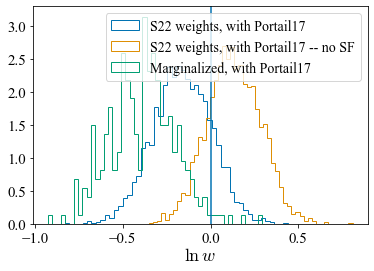

In [231]:
plt.hist(np.array(-mc_s22_ns[0].samples()['ln_w_P']), 
         bins=50, density=True, histtype='step', label='S22 weights, with Portail17');
print(np.exp(-np.nanmedian(np.array(mc_s22_ns[0].samples()['ln_w_P']))),
      np.nanstd(np.exp(-np.array(mc_s22_ns[0].samples()['ln_w_P']))))
plt.hist(np.array(-mc_s22_ns_nosf[0].samples()['ln_w_P']), 
         bins=50, density=True, histtype='step', label='S22 weights, with Portail17 -- no SF');
print(np.exp(np.nanmedian(-np.array(mc_s22_ns_nosf[0].samples()['ln_w_P']))),
      np.nanstd(np.exp(-np.array(mc_s22_ns_nosf[0].samples()['ln_w_P']))))
plt.hist(np.array(-mc_s22_ns_marg[0].samples()['ln_w_P']), 
         bins=50, density=True, histtype='step', label='Marginalized, with Portail17');
print(np.exp(np.nanmedian(-np.array(mc_s22_ns_marg[0].samples()['ln_w_P']))),
      np.nanstd(np.exp(-np.array(mc_s22_ns_marg[0].samples()['ln_w_P']))))
plt.axvline(0.)
plt.xlabel(r'$\ln w$')
plt.legend()

In [984]:
mc_s22_ns_marg = run_mcmc_no_spline(n_d_samples, 100,1000,True, False, n_samples=50, background_model='p17')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4769/2799188553.py", line 1, in <cell line: 1>
    mc_s22_ns_marg = run_mcmc_no_spline(n_d_samples, 100,1000,True, False, n_samples=50, background_model='p17')
  File "/tmp/ipykernel_4769/2723919084.py", line 71, in run_mcmc_no_spline
    init_guess = run_optimization_no_spline(n_d_samples, min_period, max_period,
  File "/tmp/ipykernel_4769/1706472287.py", line 98, in run_optimization_no_spline
    min_results = minimize(minimize_logL_numpyro, init_guess(aux_params),
  File "/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/jax/_src/scipy/optimize/minimize.py", line 105, in minimize
    results = minimize_bfgs(fun_with_args, x0, **options)
  File "/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/jax/_src/scipy/optimize/bf

## Spline model for weight 

In [155]:
mc_s22 = run_mcmc_spline(n_d_samples, True, True, knot_spacing='linear', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True, num_chains=4)
mc_s22_noSF = run_mcmc_spline(n_d_samples_noSF, True, True, knot_spacing='linear', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True, num_chains=4)
mc_s22_AGE = run_mcmc_spline(n_d_samples, True, True, knot_spacing='age', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True, num_chains=4)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:19<00:00, 122.20it/s, 15 steps of size 3.16e-01. acc. prob=0.87]


In [247]:
def run_binned_fits(samples, use_s22_weights):
    return [run_mcmc_no_spline(samples, ppl,ppu,True,use_s22_weights,
                               n_samples=600,init_with_optimization=False,background_model='p17')
            for ppl, ppu in zip(np.nanpercentile(data['period'].values, np.linspace(0.,100.,12))[:-1],
                                np.nanpercentile(data['period'].values, np.linspace(0.,100.,12))[1:])]

mc=run_binned_fits(n_d_samples, True)
mc_marg=run_binned_fits(n_d_samples, False)
mc_noSF=run_binned_fits(n_d_samples_noSF, True)
mc_marg_noSF=run_binned_fits(n_d_samples_noSF, False)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:36<00:00, 32.99it/s]


In [235]:
mc_full = run_mcmc_spline(n_d_samples, include_background_weight=True, use_s22_weights=False, 
                          knot_spacing='linear', Nknots=default_N_knots, 
                          n_samples=1200, init_with_optimization=True,
                          smoothing_hyperparameter=True,
                          prior_scales = {'ln_Rdisk':0.6, 'ln_Hdisk':0.6, 'ln_sigmaR0':0.3, 'ln_RsigmaR':0.3, 'ln_w_P':3.},
                          scaling_choice = 1.)

sample: 100%|██████████████████████████████████████| 1800/1800 [2:43:08<00:00,  5.44s/it, 63 steps of size 6.88e-02. acc. prob=0.84]


# Display results

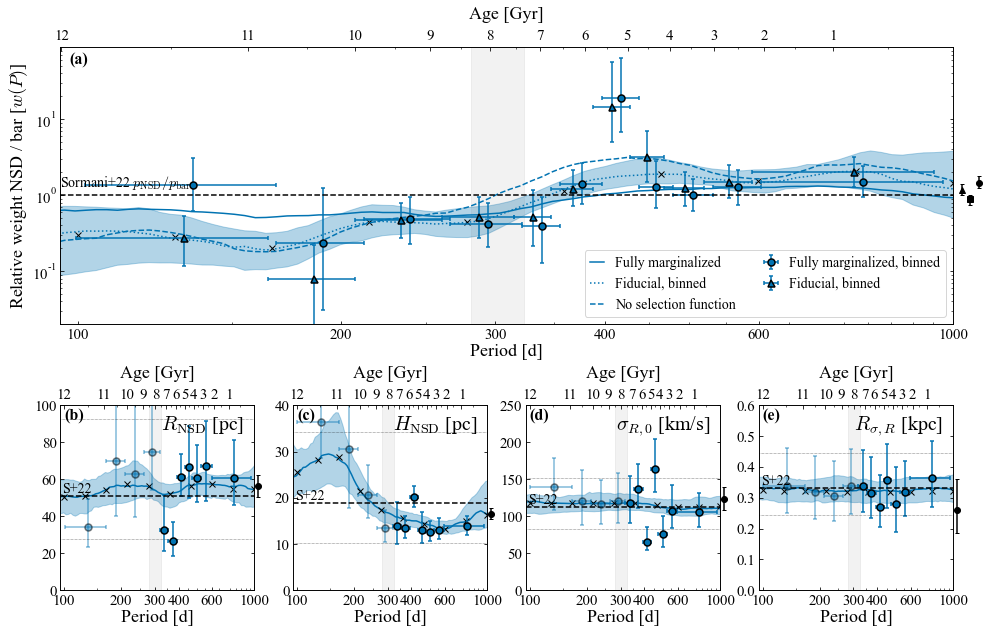

In [274]:
# Grid of results Rdisk, Hdisk, etc.
## =====================
## Plot results
## =====================

import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})
from plotting import *

# using gridspec make a grid with four plots on first line and one big one beneath
fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2,4, hspace=0.35, wspace=0.2, width_ratios=[1,1,1,1], height_ratios=[1.5,1])
ax_top = [fig.add_subplot(gs[1, i]) for i in range(4)]
ax_lower = fig.add_subplot(gs[0, :])

plt.sca(ax_lower)
# plot_spline(mc_noSF, 'ln_w_P', xrr, color=sns.color_palette('colorblind')[0])
xrr = np.linspace(1.9,3.1,100)
plot_spline(mc_full, 'ln_w_P', xrr, color=sns.color_palette('colorblind')[0], 
            one_over=True,display_knots=False,with_bracket=False,ls='-',label='Fully marginalized')
plot_spline(mc_s22, 'ln_w_P', xrr, color=sns.color_palette('colorblind')[0], 
            one_over=True,display_knots=True,ls=':',label='Fiducial, binned')
plot_spline(mc_s22_noSF, 'ln_w_P', xrr, color=sns.color_palette('colorblind')[0], 
            one_over=True,display_knots=False,with_bracket=False,ls='--',label='No selection function')
# plot_errorbar_list(mc, 'ln_w_P', scaling=1., one_over=True, label='S22')
plot_errorbar_list(mc_marg, 'ln_w_P', scaling=1., one_over=True, ps='o', label='Fully marginalized, binned',nudge=0.005)
plot_errorbar_list(mc, 'ln_w_P', scaling=1., one_over=True, ps='^', label='Fiducial, binned',nudge=-0.005)

plt.errorbar([3.01],[np.nanmedian(np.exp(mc_s22_ns[0].samples()['ln_w_P']))],
             yerr = np.vstack([np.nanmedian(np.exp(mc_s22_ns[0].samples()['ln_w_P']))-np.nanpercentile(np.exp(mc_s22_ns[0].samples()['ln_w_P']),16.),
                               -np.nanmedian(np.exp(mc_s22_ns[0].samples()['ln_w_P']))+np.nanpercentile(np.exp(mc_s22_ns[0].samples()['ln_w_P']),84.)]),
             fmt='k^',clip_on=False)
plt.errorbar([3.02],[np.nanmedian(np.exp(mc_s22_ns_nosf[0].samples()['ln_w_P']))],
             yerr = np.vstack([np.nanmedian(np.exp(mc_s22_ns_nosf[0].samples()['ln_w_P']))-np.nanpercentile(np.exp(mc_s22_ns_nosf[0].samples()['ln_w_P']),16.),
                               -np.nanmedian(np.exp(mc_s22_ns_nosf[0].samples()['ln_w_P']))+np.nanpercentile(np.exp(mc_s22_ns_nosf[0].samples()['ln_w_P']),84.)]),
             fmt='ks',ls='dashed',clip_on=False)
plt.errorbar([3.03],[np.nanmedian(np.exp(mc_s22_ns_marg[0].samples()['ln_w_P']))],
             yerr = np.vstack([np.nanmedian(np.exp(mc_s22_ns_marg[0].samples()['ln_w_P']))-np.nanpercentile(np.exp(mc_s22_ns_marg[0].samples()['ln_w_P']),16.),
                               -np.nanmedian(np.exp(mc_s22_ns_marg[0].samples()['ln_w_P']))+np.nanpercentile(np.exp(mc_s22_ns_marg[0].samples()['ln_w_P']),84.)]),
             fmt='ko',clip_on=False)


plt.legend(loc='lower right', ncol=2, handlelength=1)
plt.ylim(0.,9.)
plt.axhline(1.,ls='dashed', color='black')
# plt.ylabel(r'$[p_\mathrm{NSD}(P)/p_\mathrm{bar}(P)]/[p_\mathrm{NSD}/p_\mathrm{bar}]_\mathrm{S+22}(P)$')
plt.ylabel('Relative weight NSD / bar [$w(P)$]')
shade_bfa(add_label=False)
format_period_axis()
plt.annotate('Sormani+22 $p_\mathrm{NSD}/p_\mathrm{bar}$', (2.,1.1), fontsize=14,ha='left',va='bottom')
plt.semilogy()
plt.ylim(2e-2,9e1)
plt.xlim(2.,3.)
plt.annotate('(a)',xy=(0.01,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')

if aux_params['df_type']=='quasiisothermal':
    keys = ['ln_Rdisk', 'ln_Hdisk', 'ln_sigmaR0', 'ln_RsigmaR']#, 'ln_w_P']
    label_lookup = {'ln_Rdisk': r'$R_\mathrm{NSD}$ [pc]',
                    'ln_Hdisk': r'$H_\mathrm{NSD}$ [pc]',
                    'ln_sigmaR0': r'$\sigma_{R,0}$ [km/s]',
                    'ln_RsigmaR': r'$R_{\sigma,R}$ [kpc]',
                    'ln_w_P': r'$w(P)$'}
    scalings = {'ln_Rdisk': 1000.,
                'ln_Hdisk': 1000.,
                'ln_sigmaR0': 1.,
                'ln_RsigmaR': 1.,
                'ln_w_P': 1.}

else:
    keys = ['ln_Rdisk', 'ln_Hdisk', 'ln_sigmaR0', 'ln_RsigmaR', 'ln_w_P', 'ln_Rho0', 'ln_q']
alpha_lbls = ['(b)','(c)','(d)','(e)']
for i, k in enumerate(keys):
    plt.sca(ax_top[i])
    plt.annotate(alpha_lbls[i],xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')

    plot_spline(mc_full, k, xrr, color=sns.color_palette('colorblind')[0], 
            one_over=False,display_knots=True,ls='-',scaling=scalings[k])
    plot_errorbar_list(mc_marg, k, scaling=scalings[k], one_over=False,fade=np.log10(300.))
    plt.errorbar([3.02],[scalings[k]*np.nanmedian(np.exp(mc_s22_ns_marg[0].samples()[k]))],
                yerr = scalings[k]*np.vstack([np.nanmedian(np.exp(mc_s22_ns_marg[0].samples()[k]))
                                  -np.nanpercentile(np.exp(mc_s22_ns_marg[0].samples()[k]),16.),
                                -np.nanmedian(np.exp(mc_s22_ns_marg[0].samples()[k]))
                                +np.nanpercentile(np.exp(mc_s22_ns_marg[0].samples()[k]),84.)]),
                fmt='ko',clip_on=False)
    delta_priors = np.float64(mc_full.parameters[k].scale[0])
    plt.axhline(np.exp(min_results_s22.x[i])*scalings[k], ls='dashed', color='black')
    plt.axhline(np.exp(min_results_s22.x[i]+delta_priors)*scalings[k], ls='dotted', color='black', lw=0.5)
    plt.axhline(np.exp(min_results_s22.x[i]-delta_priors)*scalings[k], ls='dotted', color='black', lw=0.5)
    plt.annotate('S+22', (1.99, np.exp(min_results_s22.x[i])*scalings[k]), xycoords='data', ha='left', va='bottom', fontsize=14)
    
    if k=='ln_Rdisk':
        plt.ylim(0.,0.1*scalings[k])
    elif k=='ln_Hdisk':
        plt.ylim(0.,0.040*scalings[k])
    elif k=='ln_sigmaR0':
        plt.ylim(0.,250.)
    elif k=='ln_RsigmaR':
        plt.ylim(0.,0.6)

    # add annotation top right
    plt.annotate(label_lookup[k], (0.95,0.95), fontsize=20,ha='right',va='top', xycoords='axes fraction')
    shade_bfa(add_label=False)

    format_period_axis()
    
plt.savefig('plots/parameters.pdf', bbox_inches='tight')

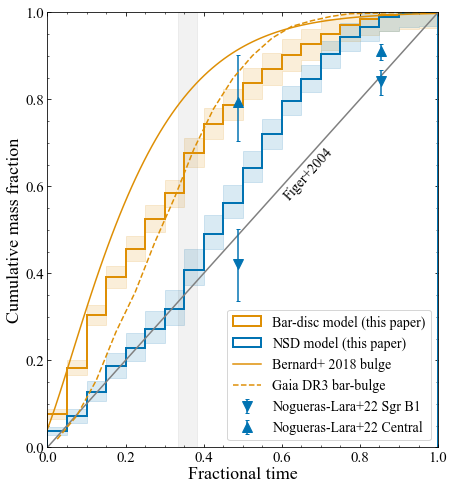

In [246]:
def add_nl_points():
        NL_max_age = 13.7
        nl,e_nl = np.array([42.,42.,7.7,2.2,5.7]), np.array([11.,11.,1.0,0.7,1.3])
        smp_nl = np.random.normal(nl,e_nl,(10000,5))
        med__=np.nanpercentile(np.cumsum(smp_nl,axis=1)/np.sum(smp_nl,axis=1)[:,np.newaxis],[16.,50.,84.],axis=0).T
        plt.errorbar([1-7/NL_max_age,1-2/NL_max_age],
                        med__[:2,1],
                        yerr=np.array([med__[:2,1]-med__[:2,0],
                                med__[:2,2]-med__[:2,1]]),
                        fmt='v', ms=10,color=sns.color_palette('colorblind')[0],label='Nogueras-Lara+22 Sgr B1')

        NL_max_age = 13.7
        nl,e_nl = np.array([79.,12.,4.9,0.7,3.2]), np.array([12.,12.,0.8,0.2,0.4])
        smp_nl = np.random.normal(nl,e_nl,(10000,5))
        med__=np.nanpercentile(np.cumsum(smp_nl,axis=1)/np.sum(smp_nl,axis=1)[:,np.newaxis],[16.,50.,84.],axis=0).T
        plt.errorbar(np.array([1-7/NL_max_age,1-2/NL_max_age,1-0.5/NL_max_age])[:2],
                        med__[:2,1],
                        yerr=np.array([med__[:,1]-med__[:,0],
                                med__[:,2]-med__[:,1]])[:,:2],
                        fmt='^', ms=10,color=sns.color_palette('colorblind')[0],label='Nogueras-Lara+22 Central')
                        
def comparison_plot(mc_s22):
        f=plt.figure(figsize=(7,8))

        _,test_spline = spline_marginalization(mc_s22.aux_parameters['aux_knots'], 
                                                np.array(mc_s22.samples()['ln_w_P']),
                                                jnp.log10(data['period'].values))
        AGE_NORM = 12.
        which='pF'
        rfw = np.exp(n_d_samples_noSF[f'denom_{which}weights']-n_d_samples[f'denom_{which}weights'])
        bar_weight = rfw*((age_period(data['period']))**0.48*np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[1])/
                (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[1])))
        _,b_d,_=plt.hist(1-age_period(data['period'])/AGE_NORM,bins=20,range=[0.,1.], weights=bar_weight,
                histtype='step',density=True,color=sns.color_palette('colorblind')[1],cumulative=True,linewidth=2,label='Bar-disc model (this paper)');
        VAR,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d, weights=bar_weight**2);
        N,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d,weights=bar_weight);
        plt.legend(loc='lower right')

        def norm_sum(x):
                return np.cumsum(x)/np.sum(x)
        def var_sum(y,x):
            return np.cumsum(y)/np.sum(x)**2
                
        mid = .5*(b_d[1:]+b_d[:-1])
        n_lower,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d,
                weights=rfw*(age_period(data['period']))**0.48*np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[0])/
                (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[0])),density=True);
        n_upper,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d,
                weights=rfw*(age_period(data['period']))**0.48*np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[2])/
                (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[2])),density=True);
        plt.fill_between(np.concatenate([[-b_d[1]+b_d[0]+mid[0]],mid,[b_d[1]-b_d[0]+mid[-1]]]),
                        np.concatenate([[0.],norm_sum(N)-np.sqrt((norm_sum(n_lower)-norm_sum(N))**2+var_sum(VAR,N)),[0.]]),
                        np.concatenate([[0.],norm_sum(N)+np.sqrt((norm_sum(n_upper)-norm_sum(N))**2+var_sum(VAR,N)),[0.]]),alpha=0.15,step='mid',
                        color=sns.color_palette('colorblind')[1])


        which='pF'
        rfw = np.exp(n_d_samples_noSF[f'denom_nsdweights']-n_d_samples[f'denom_nsdweights'])
        nsd_weight = rfw*((age_period(data['period']))**0.48*np.exp(n_d_samples[f'denom_nsdweights'])/
                (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_pFweights'])*np.exp(test_spline[1])))
        _,b_d,_=plt.hist(1-age_period(data['period'])/AGE_NORM,bins=20,range=[0.,1.], weights=nsd_weight,
                histtype='step',density=True,color=sns.color_palette('colorblind')[0],cumulative=True,linewidth=2,label='NSD model (this paper)');
        VAR,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d, weights=nsd_weight**2);
        N,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d, weights=nsd_weight);

        def norm_sum(x):
                return np.cumsum(x)/np.sum(x)
        mid = .5*(b_d[1:]+b_d[:-1])
        n_lower,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d,
                weights=rfw*(age_period(data['period']))**0.48*np.exp(n_d_samples[f'denom_nsdweights'])/
                (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[0])),density=True);
        n_upper,_=np.histogram(1-age_period(data['period'])/AGE_NORM,bins=b_d,
                weights=rfw*(age_period(data['period']))**0.48*np.exp(n_d_samples[f'denom_nsdweights'])/
                (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_pFweights'])*np.exp(test_spline[2])),density=True);
        plt.fill_between(np.concatenate([[-b_d[1]+b_d[0]+mid[0]],mid,[b_d[1]-b_d[0]+mid[-1]]]),
                        np.concatenate([[0.],norm_sum(N)-np.sqrt((norm_sum(n_lower)-norm_sum(N))**2+var_sum(VAR,N)),[0.]]),
                        np.concatenate([[0.],norm_sum(N)+np.sqrt((norm_sum(n_upper)-norm_sum(N))**2+var_sum(VAR,N)),[0.]]),alpha=0.15,step='mid',
                        color=sns.color_palette('colorblind')[0])

        xx = np.linspace(0.01,13.99,100)
        BERNARD_MAX_AGE = 13.7
        plt.plot(1-xx/BERNARD_MAX_AGE,1-np.exp(-((14-(xx-0.01))/14.*4.)**1.3),color=sns.color_palette('colorblind')[1],label='Bernard+ 2018 bulge')

        plt.plot(xx/14., xx/14., color='gray')
        plt.xlim(0,1)
        plt.xlabel('Fractional time')
        plt.ylabel('Cumulative mass fraction')
        plt.ylim(0.,1.)
        add_inner_ticks()

        add_nl_points()

        plt.axvspan(1-(7.3+0.7)/12,1-(6.7+0.7)/12, color='gray', alpha=0.1)

        plt.annotate('Figer+2004', rotation=48, xy=(0.6,0.57), fontsize=14)

        gaia_cumulative = np.load('gaia_cumulative.npy')
        plt.plot(gaia_cumulative[1],gaia_cumulative[0],color=sns.color_palette('colorblind')[1],label='Gaia DR3 bar-bulge',ls='dashed')

        plt.legend(loc='lower right')

comparison_plot(mc_s22)
plt.savefig('plots/bernard_comparison.pdf',bbox_inches='tight')

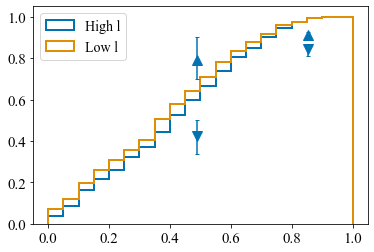

In [965]:
## Some attempt to demonstrate inside-out formation
which='pF'
_,test_spline = spline_marginalization(mc_full.aux_parameters['aux_knots'], 
                                       np.array(mc_full.samples()['ln_w_P']),
                                       jnp.log10(data['period'].values))
                                                        
def r_(x):
    return np.abs(x-360.*(x>180.))

new_full = recompute_denom(mc_full, n_d_samples) 
new_full_noSF = recompute_denom(mc_full, n_d_samples_noSF) 
rfw = np.exp(new_full_noSF- new_full)
bar_weight = rfw*((age_period(data['period']))**0.48*np.exp(new_full)/
        (np.exp(new_full)+np.exp(n_d_samples[f'denom_pFweights'])*np.exp(test_spline[1])))
_,b_d,_=plt.hist((1-age_period(data['period'])/12)[r_(data['l'])>0.6],bins=20,range=[0.,1.], weights=bar_weight[r_(data['l'])>0.6],
            histtype='step',density=True,color=sns.color_palette('colorblind')[0],cumulative=True,linewidth=2,label='High l');

_,b_d,_=plt.hist((1-age_period(data['period'])/12)[r_(data['l'])<.3],bins=20,range=[0.,1.], weights=bar_weight[r_(data['l'])<.3],
            histtype='step',density=True,color=sns.color_palette('colorblind')[1],cumulative=True,linewidth=2,label='Low l');

plt.legend()

add_nl_points()

In [968]:
# age distribution plot
import seaborn as sns
from scipy.stats import gaussian_kde

def make_age_distribution_plot(model, n_d_samples, fig=None, sfh=True, with_gc=True, reweight=None, add_labels=True, include_poisson=True):

    if fig is None: 
        fig=plt.figure(figsize=[7.,5.])


    _,test_spline = spline_marginalization(model.aux_parameters['aux_knots'], 
                                         np.array(model.samples()['ln_w_P']),
                                         jnp.log10(data['period'].values))
    
    which = {'p17':'pF', 'dd':'dd'}[model.aux_parameters['background_model']]

    def extra_weight(age):
        if sfh:
            return age**0.48
        return np.ones_like(age)
    

    def plot_hist_weight(weight_, color=sns.color_palette('colorblind')[0], print_=False):

        _,b_d,_=plt.hist(age_period(data['period']),bins=20,range=[0.5,10.5+1.5*with_gc], weights=weight_[1], 
                        histtype='step',density=True,color=color);
        sns.kdeplot(age_period(data['period']), bw_adjust=0.5, weights=weight_[1], color=color)
        GK=gaussian_kde(age_period(data['period']), weights=weight_[1], bw_method=0.5*len(data) ** (-1 / 5.))

        if print_:
            xxy = np.linspace(5.,11.,1000)
            print(.5*(xxy[1:]+xxy[:-1])[np.argmax(np.abs(np.diff(GK(xxy))))])

        n_d,_=np.histogram(age_period(data['period']),bins=b_d,weights=weight_[1])
        VARn_d,_=np.histogram(age_period(data['period']),bins=b_d,weights=weight_[1]**2);
        norm = np.sum(n_d)*np.diff(b_d)[0]
        
        n_lower,_=np.histogram(age_period(data['period']), bins=b_d, weights=weight_[0]);
        n_lower = (n_d-np.sqrt(include_poisson*VARn_d+(n_lower/np.sum(n_lower)-n_d/np.sum(n_d))**2*np.sum(n_d)**2))/norm
        n_upper,_=np.histogram(age_period(data['period']), bins=b_d, weights=weight_[2]);
        n_upper = (n_d+np.sqrt(include_poisson*VARn_d+(n_upper/np.sum(n_upper)-n_d/np.sum(n_d))**2*np.sum(n_d)**2))/norm
        
        mid = .5*(b_d[1:]+b_d[:-1])
        plt.fill_between(np.concatenate([mid,[b_d[1]-b_d[0]+mid[-1]]]),np.concatenate([n_lower,[0.]]),np.concatenate([n_upper,[0.]]),
                        alpha=0.15,step='mid',
                        color=color)

    if not model.aux_parameters['use_s22_weights']:
        denom = recompute_denom(model, n_d_samples) 
        denom_noSF = recompute_denom(model, reweight) 
    else:
        denom = n_d_samples['denom_nsdweights']
        if reweight is not None:
            denom_noSF = reweight['denom_nsdweights']

    if reweight is not None:
        rfw = np.exp(reweight[f'denom_{which}weights']-n_d_samples[f'denom_{which}weights'])
    else:
        rfw = 1.

    bar_weight = [rfw*(extra_weight(age_period(data['period']))*np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[i])/
            (np.exp(denom)+np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[i]))) for i in range(3)]
    
    plot_hist_weight(bar_weight, color=sns.color_palette('colorblind')[1], print_=False)

    if reweight is not None:
        rfw = np.exp(denom_noSF - denom)
    else:
        rfw = 1.

    nsd_weight = [rfw*extra_weight(age_period(data['period']))*np.exp(denom)/\
                  (np.exp(denom)+np.exp(n_d_samples[f'denom_{which}weights'])*np.exp(test_spline[i])) for i in range(3)]

    plot_hist_weight(nsd_weight, color=sns.color_palette('colorblind')[0], print_=True)
    # xx = np.linspace(0.,14.,1000)
    # plt.plot(xx/1.2,((1-np.exp(-((14-(xx-0.01))/14.*4.)**1.3))-(1-np.exp(-((14-xx)/14.*4.)**1.3)))/0.01,color='k')

    if add_labels:
        plt.annotate('"Background" disc', xy=(6.,0.03), fontsize=12,ha='center')
        plt.annotate('Bar/bulge', xy=(10.6,0.13), fontsize=12,ha='center')

        plt.annotate('NSD', xy=(6.2,0.16), fontsize=16,ha='center')

        if with_gc==True:
            delta=0.7
        else:
            delta=0.

        plt.axvspan(6.8+delta,7.8+delta,color='k',alpha=0.1)
        plt.annotate('Bar formation epoch', rotation=90, xy=(7.3+delta,0.17), fontsize=15,ha='center')

    plt.ylim(0.,0.26)

    from plotting_general import add_inner_ticks
    add_inner_ticks()
    plt.xlim(0.,10.5+1.5*with_gc)

    plt.xlabel('Age [Gyr]')
    plt.ylabel('Age distribution [Gyr$^{-1}$]')
    if sfh:
        plt.ylabel('Star formation history [$\propto M_\odot$ Gyr$^{-1}$]')


7.885885885885886


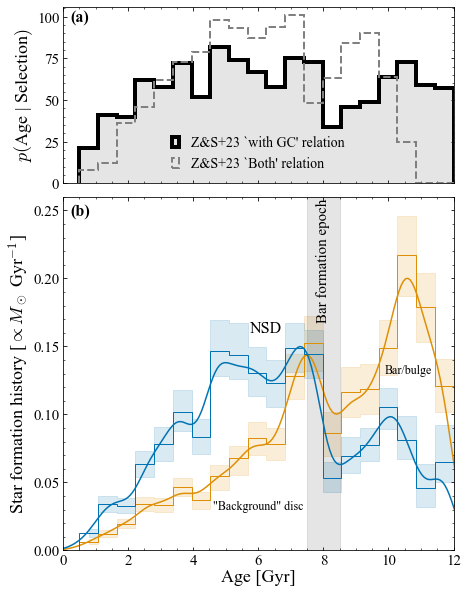

In [978]:
def sfh_plot(model):
    f,a=plt.subplots(2,1,figsize=(7,10),gridspec_kw={'height_ratios':[0.5,1.]},sharex=True)
    plt.subplots_adjust(hspace=0.05)

    plt.sca(a[0])
    plt.hist(age_period(data["period"], with_gc=True), bins=20, histtype="step", lw=4, range=[0.5,12.], color='k',
            label="Z&S+23 `with GC' relation");
    plt.hist(age_period(data["period"], with_gc=True), bins=20, histtype="stepfilled", lw=4, range=[0.5,12.], color='k',alpha=0.1)
    plt.hist(age_period(data["period"], with_gc=False), bins=20, histtype="step", lw=2, range=[0.5,12.], color='gray',
            label="Z&S+23 `Both' relation",ls='dashed');
    plt.legend(loc='lower center', fontsize=14,handlelength=0.5,frameon=False)

    add_inner_ticks()

    plt.ylabel('$p($Age | Selection$)$')

    plt.sca(a[1])
    make_age_distribution_plot(model,n_d_samples,a[1], reweight=n_d_samples_noSF, sfh=True)
    plt.sca(a[0])
    plt.annotate('(a)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
    plt.sca(a[1])
    plt.annotate('(b)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
    plt.savefig('plots/sfh.pdf', bbox_inches='tight')

sfh_plot(mc_s22)
plt.savefig('plots/sfh.pdf', bbox_inches='tight')

In [56]:
from model import generate_samples

samples_map_TEST=generate_samples(mc_s22_SM_TEST_all, bar_model, data=None, add_errors=True, Nsamples=50000, SF=SF)

{'ln_Hdisk': array([-3.48195766, -3.52790383, -4.46972485, -4.23658287]), 'ln_Hdisk_smooth': 0.5137580471587324, 'ln_Rdisk': array([-2.90560798, -2.91861151, -2.87946798, -2.89332219]), 'ln_Rdisk_smooth': 0.2065145699105527, 'ln_RsigmaR': array([-1.38865947, -1.39898475, -1.34062185, -1.31924205]), 'ln_RsigmaR_smooth': 0.18978084074859553, 'ln_sigmaR0': array([4.88841859, 4.89185532, 4.78108284, 4.78478007]), 'ln_sigmaR0_smooth': 0.20522165646975224, 'ln_w_P': array([ 0.57227897,  0.70640759, -0.24630992, -0.0363819 ]), 'ln_w_P_smooth': 0.9223123736809002}


Including background
Spline model for relative weight


In [971]:
## ===================================
## Generate samples for MAP parameters
## ===================================
from model import generate_samples

samples_map=generate_samples(mc_s22, bar_model, data=data, add_errors=True, Nsamples=150000, SF=SF)

Using S22 weights
Including background
Spline model for relative weight


If these two sets of distributions look similar I think the reweighting works correctly


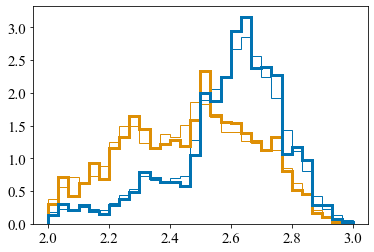

In [974]:
## Check if the reweighting works correctly
print('If these two sets of distributions look similar I think the reweighting works correctly')
plt.hist(samples_map[:,6][(samples_map[:,-1]<0.5)],bins=30,histtype='step',range=[2,3],density=True,color=sns.color_palette('colorblind')[0]);
plt.hist(samples_map[:,6][(samples_map[:,-1]>0.5)],bins=30,histtype='step',range=[2,3],density=True,color=sns.color_palette('colorblind')[1]);

xrr = jnp.linspace(1.98,3.,100)
test_spline = [InterpolatedUnivariateSpline(mc_s22.aux_parameters['aux_knots'], 
                                            np.nanpercentile(np.array(mc_s22.samples()['ln_w_P']), x, axis=0), k=3) 
                for x in [16,50,84]]

# test_spline=[None,lambda x: np.ones_like(x)*run_optimization_no_spline(n_d_samples_nopml, 100.,1000.,True,'dd',True).x[0], None]

n_d,b_d,_=plt.hist(np.log10(data['period']),bins=30,range=[2.,3.],
         weights=np.exp(n_d_samples['denom_pFweights'])*np.exp(test_spline[1](jnp.log10(data['period'].values)))/
         (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples['denom_pFweights'])*np.exp(test_spline[1](jnp.log10(data['period'].values)))),
         histtype='step',density=True,color=sns.color_palette('colorblind')[1],lw=3);

n_d,b_d,_=plt.hist(np.log10(data['period']),bins=30,range=[2.,3.],
         weights=np.exp(n_d_samples['denom_nsdweights'])/
         (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples['denom_pFweights'])*np.exp(test_spline[1](jnp.log10(data['period'].values)))),
         histtype='step',density=True,color=sns.color_palette('colorblind')[0],lw=3);

In [280]:
# Velocity plot grid

from plotting_general import add_inner_ticks
from statsmodels.stats.rates import confint_poisson


def w_(x,y=None):
    if y is not None:
        return np.ones(np.count_nonzero(y))/np.count_nonzero(x)
    return np.ones(np.count_nonzero(x))/np.count_nonzero(x)

def r_(x):
    return np.abs(x-360.*(x>180.))

def make_panel(data_fltr, fltr, samples, fld):
    
    fld_no = {'pml':3, 'pmb':4, 'joint_rv':5}[fld]
    rangex = {'pml':[-70,10], 'pmb':[-40,40], 'joint_rv':[-310,310]}[fld]

    bbins=np.histogram_bin_edges(data[fld].values[data_fltr],bins='fd',range=rangex)
    bbins= 10 if fld=='joint_rv' else 15 
    n_d,b_d,_=plt.hist(data[fld].values[data_fltr],bins=bbins,histtype='step',color='gray',lw=2.5,label='Data');
    lower,upper=confint_poisson(n_d,1.,method='exact-c',alpha=1-0.6827)
    plt.fill_between(np.concatenate([[-(b_d[1]-b_d[0])+.5*(b_d[1:]+b_d[:-1])[0]],.5*(b_d[1:]+b_d[:-1]),[b_d[1]-b_d[0]+.5*(b_d[1:]+b_d[:-1])[-1]]]),
                    np.concatenate([[0.],lower,[0.]]),np.concatenate([[0.],upper,[0.]]),
                    alpha=0.15,step='mid',
                    color='gray')
    
    plt.xlim(*rangex)

    from scipy.stats import gaussian_kde

    mid = np.linspace(*rangex,100)
    KK=gaussian_kde(samples[:,fld_no][(samples[:,-1]<0.5)&fltr],weights=w_(fltr,(samples[:,-1]<0.5)&fltr))
    l,=plt.plot(mid,KK.evaluate(mid)*np.count_nonzero(data_fltr)*np.diff(b_d)[0]*np.count_nonzero((samples[:,-1]<0.5)&fltr)/np.count_nonzero(fltr),
            color=sns.color_palette('colorblind')[0],lw=1.3,label='NSD')
    l.set_dashes([3,1])

    KK=gaussian_kde(samples[:,fld_no][(samples[:,-1]>0.5)&fltr],weights=w_(fltr,(samples[:,-1]>0.5)&fltr))
    l,=plt.plot(mid,KK.evaluate(mid)*np.count_nonzero(data_fltr)*np.diff(b_d)[0]*np.count_nonzero((samples[:,-1]>0.5)&fltr)/np.count_nonzero(fltr),
            color=sns.color_palette('colorblind')[1],lw=1.3,label='Bar')
    l.set_dashes([5,2])

    KK=gaussian_kde(samples[:,fld_no][fltr],weights=w_(fltr))
    plt.plot(mid,KK.evaluate(mid)*np.count_nonzero(data_fltr)*np.diff(b_d)[0],color=sns.color_palette('colorblind')[2],lw=2,label='Total')

    axhline = -6.411*4.74 if fld=='pml' else -7.25/8.275
    plt.axvline(axhline,color='k',ls='--',lw=1.5)

    add_inner_ticks()

def make_velocity_plot_grid(samples):
    per_grid = [100,200,250,300,350,400,500,600,1000]

    f,a=plt.subplots(3,len(per_grid)-1,figsize=(18,7.5),sharey=False,sharex=False)
    plt.subplots_adjust(hspace=0.4,wspace=0.03)

    for j, (pl, pu) in enumerate(zip(per_grid[:-1],per_grid[1:])):
        per_bin = [pl,pu]
        for i, fld in enumerate(['pml', 'pmb', 'joint_rv']):
            plt.sca(a[i][j])

            data_fltr = (np.abs(data['b'])<0.4)&(data['period']<per_bin[1])&(data['period']>per_bin[0])&(data[fld]>-1000)
            if np.count_nonzero(data_fltr)<7:
                plt.axis('off')
                continue
            fltr = (np.abs(samples[:,1])<np.deg2rad(0.4))&(samples[:,6]<np.log10(per_bin[1]))&(samples[:,6]>np.log10(per_bin[0]))

            make_panel(data_fltr, fltr, samples, fld)

            if i==0:
                plt.annotate(f'$N$={np.count_nonzero(data_fltr)}',xy=(0.02,0.95),xycoords='axes fraction',fontsize=19,va='top',ha='left')
            if i==1:
                plt.annotate(r'$\frac{p_\mathrm{NSD}}{p_\mathrm{Bar}} = %0.1f$'%(np.count_nonzero((samples[:,-1]<0.5)&fltr)/np.count_nonzero((samples[:,-1]>0.5)&fltr)),
                            xy=(0.02,0.95),xycoords='axes fraction',fontsize=13,va='top',ha='left')

            if i==0:
                plt.title(r'$P\in$[%i, %i] d''\n'r'$\tau\in$[%0.1f, %0.1f] Gyr'%(
                                                            per_bin[0],
                                                            per_bin[1],
                                                            age_period(per_bin[0]),
                                                            age_period(per_bin[1])),fontsize=15)
            # turn off y tick labels
            plt.gca().set_yticklabels([])
            plt.grid(lw=0.2)

            if j==3:
                plt.xlabel(r'$\mu_%s\,[\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1}]$'%('\ell' if fld=='pml' else 'b'),
                        x=1.1,ha='center',fontsize=18)
            if j==6 and i==2:
                plt.xlabel(r'$v_\mathrm{los} [\mathrm{km\,s}^{-1}]$',fontsize=18)
            if j==2 and i==1:
                plt.legend(handlelength=2,ncol=2,loc='lower left',bbox_to_anchor=(1.1,-1.3),fontsize=15,borderpad=0.6,handletextpad=0.5,frameon=False)


def make_velocity_plot_grid_onsky(samples):
    l_grid = [0.,0.4,0.8,1.2,1.5]
    b_grid = [0.,0.1,0.2,0.3,0.4]

    f,a=plt.subplots(3,len(b_grid)+len(l_grid)-1,figsize=(18,7.5),sharey=False,sharex=False,gridspec_kw={'width_ratios':[1,1,1,1,0.1,1,1,1,1]})
    plt.subplots_adjust(hspace=0.4,wspace=0.03)

    for i in range(3):
        plt.sca(a[i][4])
        plt.axis('off')

    for j, (ll, lu) in enumerate(zip(l_grid[:-1],l_grid[1:])):
        l_bin = [ll,lu]
        for i, fld in enumerate(['pml', 'pmb', 'joint_rv']):
            plt.sca(a[i][j])
            data_fltr = (np.abs(data['b'])<0.4)&(r_(data['l'])<l_bin[1])&(r_(data['l'])>l_bin[0])&(data[fld]>-1000)

            if np.count_nonzero(data_fltr)<7:
                plt.axis('off')
                continue

            fltr = (np.abs(samples[:,1])<np.deg2rad(0.4))&(np.abs(np.rad2deg(samples[:,0]))<l_bin[1])&(np.abs(np.rad2deg(samples[:,0]))>l_bin[0])
            make_panel(data_fltr, fltr, samples, fld)

            if i==0:
                plt.annotate(f'$N$={np.count_nonzero(data_fltr)}',xy=(0.02,0.95),xycoords='axes fraction',fontsize=19,va='top',ha='left')
            if i==1:
                plt.annotate(r'$\frac{p_\mathrm{NSD}}{p_\mathrm{bar}} = %0.1f$'%(np.count_nonzero((samples[:,-1]<0.5)&fltr)/np.count_nonzero((samples[:,-1]>0.5)&fltr)),
                            xy=(0.02,0.95),xycoords='axes fraction',fontsize=13,va='top',ha='left')

            
            if i==0:
                plt.title(r'$|\ell|\in$[%0.1f, %0.1f] deg'%(l_bin[0],
                                                            l_bin[1]),fontsize=15)
            # turn off y tick labels
            plt.gca().set_yticklabels([])
            plt.grid(lw=0.2)

            if j==3 and i<2:
                plt.xlabel(r'$\mu_%s\,[\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1}]$'%('\ell' if fld=='pml' else 'b'),
                        x=1.1,ha='center',fontsize=18)
            if j==2 and i==1:
                plt.legend(handlelength=2,ncol=1,loc='lower left',bbox_to_anchor=(1.1,-1.5),fontsize=15,borderpad=0.6,handletextpad=0.5,frameon=False)

    for j, (bl, bu) in enumerate(zip(b_grid[:-1],b_grid[1:])):
        b_bin = [bl,bu]
        for i, fld in enumerate(['pml', 'pmb', 'joint_rv']):
            plt.sca(a[i][j+5])
            data_fltr = (np.abs(data['b'])<0.4)&(r_(data['b'])<b_bin[1])&(r_(data['b'])>b_bin[0])&(data[fld]>-1000)

            if np.count_nonzero(data_fltr)<7:
                plt.axis('off')
                continue

            fltr = (np.abs(samples[:,1])<np.deg2rad(0.4))&(np.abs(np.rad2deg(samples[:,1]))<b_bin[1])&(np.abs(np.rad2deg(samples[:,1]))>b_bin[0])
            make_panel(data_fltr, fltr, samples, fld)

            if i==0:
                plt.annotate(f'$N$={np.count_nonzero(data_fltr)}',xy=(0.02,0.95),xycoords='axes fraction',fontsize=19,va='top',ha='left')
            if i==1:
                plt.annotate(r'$\frac{p_\mathrm{NSD}}{p_\mathrm{bar}} = %0.1f$'%(np.count_nonzero((samples[:,-1]<0.5)&fltr)/np.count_nonzero((samples[:,-1]>0.5)&fltr)),
                            xy=(0.02,0.95),xycoords='axes fraction',fontsize=13,va='top',ha='left')
            if i==0:
                plt.title(r'$|b|\in$[%0.1f, %0.1f] deg'%(b_bin[0],
                                                            b_bin[1]),fontsize=15)
            if j==0 and i==2:
                plt.xlabel(r'$v_\mathrm{los} [\mathrm{km\,s}^{-1}]$',fontsize=18,x=-0.1,ha='center')
            # turn off y tick labels
            plt.gca().set_yticklabels([])
            plt.grid(lw=0.2)


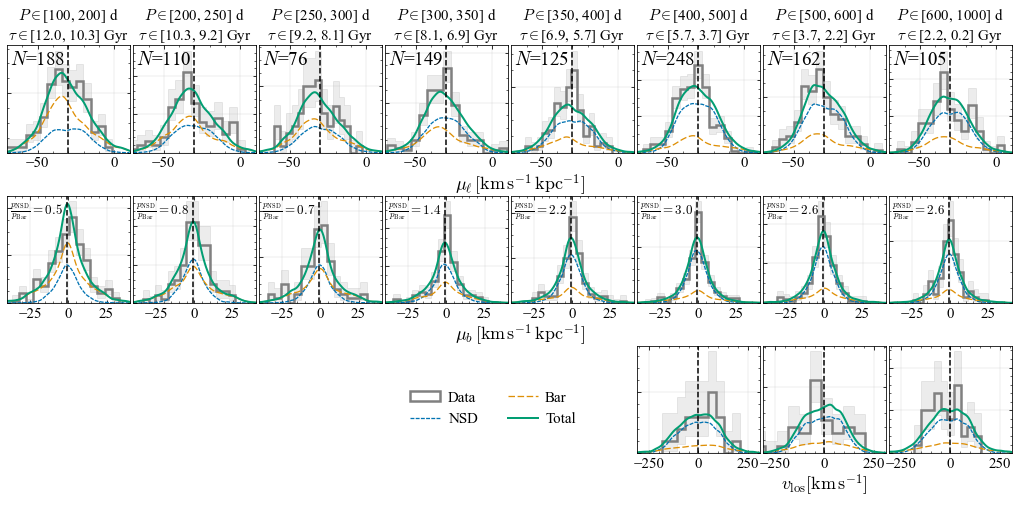

In [976]:
make_velocity_plot_grid(samples_map)
plt.savefig('plots/veldists.pdf', bbox_inches='tight')

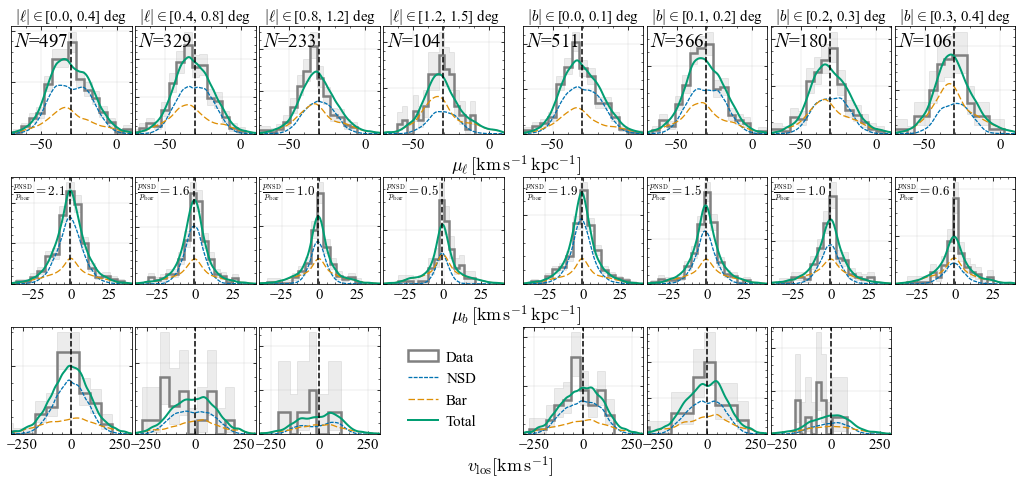

In [977]:
make_velocity_plot_grid_onsky(samples_map)
plt.savefig('plots/veldists_onsky.pdf', bbox_inches='tight')

## Outside view

In [157]:
outside_samples_map=generate_samples(mc_s22, bar_model, data=None, add_errors=False, Nsamples=500000,onskylimit=5.)

Using S22 weights
Including background
Spline model for relative weight


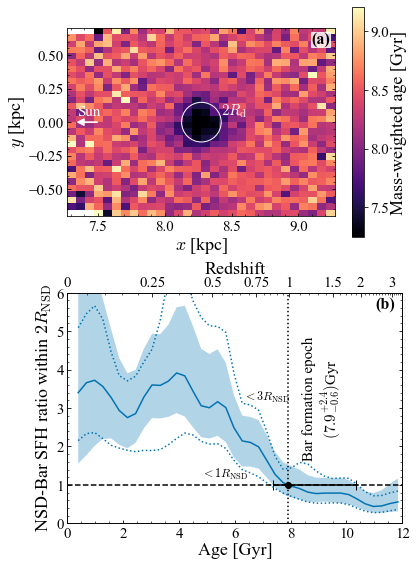

In [166]:
# binned stat 2d imshow

f,a = plt.subplots(2,1,figsize=(6,9.5))
plt.subplots_adjust(hspace=0.24)
plt.sca(a[0])
from scipy.stats import binned_statistic_2d
_, test_spline = spline_marginalization(mc_s22.aux_parameters['aux_knots'], 
                                         np.array(mc_s22.samples()['ln_w_P']),
                                         jnp.log10(data['period'].values))
# noSF on top as removes SF effect
nsd_weight = age_period(data['period'])**0.48*np.exp(n_d_samples_noSF['denom_nsdweights'])/\
            (np.exp(n_d_samples['denom_nsdweights'])+np.exp(n_d_samples[f'denom_pFweights'])*np.exp(test_spline[1]))
n,b=np.histogram(age_period(data['period']), weights=nsd_weight,bins=40); # gives p_NSD(P)
n2,b=np.histogram(age_period(np.power(10.,outside_samples_map[:,6]))[outside_samples_map[:,-1]!=1],bins=b) # should be approx. uniform
rw = np.interp(age_period(np.power(10.,outside_samples_map[:,6])),.5*(b[1:]+b[:-1]),n/n2)

bb = binned_statistic_2d(outside_samples_map[:,2]*np.cos(outside_samples_map[:,0])*np.cos(outside_samples_map[:,1]),
           outside_samples_map[:,2]*np.sin(outside_samples_map[:,0])*np.cos(outside_samples_map[:,1]),
           rw*age_period(np.power(10.,outside_samples_map[:,6])),bins=30,range=[[8.275-1.,8.275+1.],[-0.7,0.7]]);
bb2 = binned_statistic_2d(outside_samples_map[:,2]*np.cos(outside_samples_map[:,0])*np.cos(outside_samples_map[:,1]),
           outside_samples_map[:,2]*np.sin(outside_samples_map[:,0])*np.cos(outside_samples_map[:,1]),
           rw,bins=30,range=[[8.275-1.,8.275+1.],[-0.7,0.7]]);

plt.imshow(bb.statistic.T/bb2.statistic.T, origin='lower', 
          vmin=np.nanpercentile(bb.statistic.T/bb2.statistic.T,1.)-0.1,
          vmax=np.nanpercentile(bb.statistic.T/bb2.statistic.T,99.)+0.1, 
          aspect='auto', cmap='magma',
          extent=[bb.x_edge[0], bb.x_edge[-1],bb.y_edge[0], bb.y_edge[-1]])
plt.colorbar(label='Mass-weighted age [Gyr]')
plt.gca().set_aspect('equal')
add_inner_ticks()
# draw circle
circle = plt.Circle((8.275, 0), 0.074*2, color='white', fill=False, lw=1)
plt.gca().add_artist(circle)
plt.annotate(r'$2R_\mathrm{d}$',(8.275+2*0.074,0.05),color='white',fontsize=15)
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')


plt.arrow(7.5, 0, -0.1, 0, head_width=0.05, head_length=0.05, fc='w', ec='w')
plt.annotate('Sun', (7.35, 0.05), fontsize=15,color='w')


plt.sca(a[1])
smw = 1.
for times_scale in [1.,2.,3.]:
        inside_ = np.hypot(8.275-outside_samples_map[:,2]*np.cos(outside_samples_map[:,0])*np.cos(outside_samples_map[:,1]),
                        outside_samples_map[:,2]*np.sin(outside_samples_map[:,0])*np.cos(outside_samples_map[:,1]))<0.074*times_scale
        n,b=np.histogram(age_period(np.power(10.,outside_samples_map[inside_ & (outside_samples_map[:,-1]<0.5),6])),bins=b,
                weights=rw[inside_ & (outside_samples_map[:,-1]<0.5)])
        n2,b=np.histogram(age_period(np.power(10.,outside_samples_map[inside_ & (outside_samples_map[:,-1]>0.5),6])),bins=b,
                weights=rw[inside_ & (outside_samples_map[:,-1]>0.5)])
        from scipy.ndimage import gaussian_filter1d
        LS = '-'
        if times_scale!=2.:
            LS = 'dotted'
        plt.plot(.5*(b[1:]+b[:-1]),gaussian_filter1d(n/n2,smw,mode='nearest'),c=sns.color_palette('colorblind')[0],label='NSD/Bar',
                 ls=LS)

        if times_scale!=2.:
            continue
        _, test_spline_bins = spline_marginalization(mc_s22.aux_parameters['aux_knots'], 
                                                np.array(mc_s22.samples()['ln_w_P']),
                                                np.log10(period_age(.5*(b[1:]+b[:-1]))),Ns=200)
        plt.fill_between(.5*(b[1:]+b[:-1]),gaussian_filter1d(n/n2*np.exp(test_spline_bins[0]-test_spline_bins[1]),smw,mode='nearest'),
                                        gaussian_filter1d(n/n2*np.exp(test_spline_bins[2]-test_spline_bins[1]),smw,mode='nearest'), alpha=0.3)

        fltr = (.5*(b[1:]+b[:-1])>6.)&(.5*(b[1:]+b[:-1])<11.)
        plt.axvline(np.interp(np.array([1.]),(gaussian_filter1d((n/n2),smw,mode='nearest'))[fltr][::-1],
        .5*(b[1:]+b[:-1])[fltr][::-1]),c='k',ls=':')
        Y,YL,YU=(np.interp(np.array([1.]),(gaussian_filter1d((n/n2),smw,mode='nearest'))[fltr][::-1],
        .5*(b[1:]+b[:-1])[fltr][::-1])[0],
        np.interp(np.array([1.]),(gaussian_filter1d((n/n2)*np.exp(test_spline_bins[0]-test_spline_bins[1]),smw,mode='nearest'))[fltr][::-1],
        .5*(b[1:]+b[:-1])[fltr][::-1])[0],
        np.interp(np.array([1.]),(gaussian_filter1d((n/n2)*np.exp(test_spline_bins[2]-test_spline_bins[1]),smw,mode='nearest'))[fltr][::-1],
        .5*(b[1:]+b[:-1])[fltr][::-1])[0]
        )

        plt.errorbar(Y,1.,xerr=np.array([[Y-YL],[YU-Y]]),c='k',fmt='o',capsize=5)
        plt.annotate('Bar formation epoch\n      $(%0.1f^{+%0.1f}_{-%0.1f})$Gyr'%(Y,YU-Y,Y-YL), rotation=90, xy=[8.4,1.8],fontsize=15)

plt.ylabel(r'NSD-Bar SFH ratio within $2 R_\mathrm{NSD}$')
plt.xlabel(r'Age [Gyr]')
plt.ylim(0.,6.)        
plt.axhline(1.,color='k',ls='--')
add_inner_ticks()

plt.annotate(r'$<1R_\mathrm{NSD}$', (4.8,1.2), fontsize=12)
plt.annotate(r'$<3R_\mathrm{NSD}$', (6.3,3.2), fontsize=12)

plt.xlim(0.,12.)
plt.gca().twiny()
plt.xlim(0.,12.)
plt.gca().tick_params(axis="x",direction="in")
plt.gca().tick_params(axis="x",direction="in",which='minor')
plt.xlabel('Redshift')
from astropy import cosmology
plt.gca().set_xticks(cosmology.Planck18.lookback_time([0,0.25,0.5,0.75,1,1.5,2,3]).value, [0,0.25,0.5,0.75,1,1.5,2,3]);
plt.gca().set_xticks(cosmology.Planck18.lookback_time([0,0.05,0.1,0.15,0.2,0.3,0.35,0.4,0.45,0.55,0.6,0.65,0.7,0.8,0.85,0.9,0.95,
                                                      1.1,1.2,1.3,1.4,1.6,1.7,1.8,1.9,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.1,3.2,3.3,3.4,3.5]).value, None,minor=True);

plt.sca(a[0])
t=plt.annotate('(a)',xy=(0.98,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='right',va='top', color='k')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0.06))
plt.sca(a[1])
plt.annotate('(b)',xy=(0.98,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='right',va='top')

plt.savefig('plots/from_outside.pdf', bbox_inches='tight')

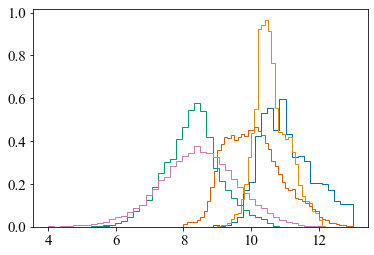

In [296]:
plt.hist(data['Ks_mean_model'],density=True,range=[4,13],bins=50,histtype='step');

NSD_fltr = (outside_samples_map[:,-1]<0.5)&(np.abs(outside_samples_map[:,0])<np.deg2rad(1.5))&(np.abs(outside_samples_map[:,1])<np.deg2rad(1.5))
plt.hist(
    (SF.plr(np.power(10.,outside_samples_map[:,6]))+5*np.log10(100.*outside_samples_map[:,2])
    +SF.smap.query(np.rad2deg(outside_samples_map[:,0]),np.rad2deg(outside_samples_map[:,1]),outside_samples_map[:,2])*1.3)[NSD_fltr]
,weights=rw[NSD_fltr],range=[8,13],bins=50,density=True,histtype='step');

plt.hist(
    (SFtest.plr(np.power(10.,outside_samples_map[:,6]))+5*np.log10(100.*outside_samples_map[:,2])
    +SFtest.smap.query(np.rad2deg(outside_samples_map[:,0]),np.rad2deg(outside_samples_map[:,1]),outside_samples_map[:,2])*1.3)[NSD_fltr]
,weights=rw[NSD_fltr],range=[4,13],bins=50,density=True,histtype='step');

BAR_fltr = (outside_samples_map[:,-1]>0.5)&(np.abs(outside_samples_map[:,0])<np.deg2rad(1.5))&(np.abs(outside_samples_map[:,1])<np.deg2rad(1.5))
BAR_fltr &(np.abs(outside_samples_map[:,1])>np.deg2rad(0.5))
plt.hist(
    (SF.plr(np.power(10.,outside_samples_map[:,6]))+5*np.log10(100.*outside_samples_map[:,2])
    +SF.smap.query(np.rad2deg(outside_samples_map[:,0]),np.rad2deg(outside_samples_map[:,1]),outside_samples_map[:,2])*1.3)[BAR_fltr]
,weights=rw[BAR_fltr],range=[8,13],bins=50,density=True,histtype='step');

plt.hist(
    (SFtest.plr(np.power(10.,outside_samples_map[:,6]))+5*np.log10(100.*outside_samples_map[:,2])
    +SFtest.smap.query(np.rad2deg(outside_samples_map[:,0]),np.rad2deg(outside_samples_map[:,1]),outside_samples_map[:,2])*1.3)[BAR_fltr]
,weights=rw[BAR_fltr],range=[4,13],bins=50,density=True,histtype='step');


# No Pml

In [276]:
n_d_samples_nopml = generate_numerator_and_denominator_samples(data, bar_model, 
                                                         N_num_samples=500, 
                                                         N_denom_samples=1000, 
                                                         SF=SF,
                                                         include_radial_velocities=False,
                                                         include_pml=False)

In [363]:
n_d_samples_nopml_noSF = generate_numerator_and_denominator_samples(data, bar_model_nodist, 
                                                         N_num_samples=500, 
                                                         N_denom_samples=1000, 
                                                         SF=None,
                                                         include_radial_velocities=False,
                                                         include_pml=False)

In [147]:
data_scaled = load_mira_sample(lowb=True, sig_clip=3., reliable=True, 
                        high_amp=True, per_cut=[100.,1000.], 
                        scale_proper_motion_errors=True)
n_d_samples_scaled = generate_numerator_and_denominator_samples(data_scaled, bar_model, 
                                                         N_num_samples=500, 
                                                         N_denom_samples=1000, 
                                                         SF=SF,
                                                         include_radial_velocities=False)

In [364]:
n_d_samples_scaled_noSF = generate_numerator_and_denominator_samples(data_scaled, bar_model_nodist, 
                                                         N_num_samples=500, 
                                                         N_denom_samples=1000, 
                                                         SF=None,
                                                         include_radial_velocities=False)

In [277]:
mc_s22_nopml = run_mcmc_spline(n_d_samples_nopml, True, True, knot_spacing='linear', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True)

sample: 100%|███████████████████████████████████████████████████| 2400/2400 [00:21<00:00, 109.96it/s, 7 steps of size 3.61e-01. acc. prob=0.80]


In [275]:
mc_s22_nopml = run_mcmc_spline(n_d_samples_nopml, True, True, knot_spacing='linear', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True)
mc_s22_scaled = run_mcmc_spline(n_d_samples_scaled, True, True, knot_spacing='linear', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True)
mc_s22_age = run_mcmc_spline(n_d_samples, True, True, knot_spacing='age', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3200/3200 [01:43<00:00, 30.89it/s]


In [523]:
mc_s22_age = run_mcmc_spline(n_d_samples, True, True, knot_spacing='age', 
                         Nknots=default_N_knots, n_samples=1600, background_model='p17',
                         smoothing_hyperparameter=True)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3200/3200 [01:17<00:00, 41.03it/s]


7.885885885885886
7.897897897897898
7.873873873873873
7.873873873873873
7.897897897897898
7.891891891891892


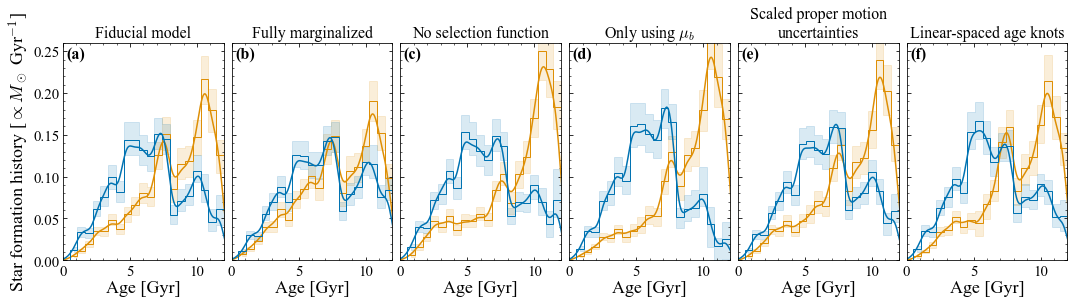

In [969]:
## 5 panels -- default, fully marginalized, no selection function, no pml, scaled pms
f,a=plt.subplots(1,6,figsize=(18,4),sharey=True)
plt.subplots_adjust(wspace=0.05)
plt.sca(a[0])
make_age_distribution_plot(mc_s22, n_d_samples, a[0], reweight=n_d_samples_noSF, sfh=True, add_labels=False)
plt.title('Fiducial model',fontsize=16)
plt.annotate('(a)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[1])
make_age_distribution_plot(mc_full, n_d_samples, a[1], reweight=n_d_samples_noSF, sfh=True, add_labels=False)
plt.title('Fully marginalized',fontsize=16)
plt.annotate('(b)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[2])
make_age_distribution_plot(mc_s22_noSF, n_d_samples_noSF, a[2], reweight=None, sfh=True, add_labels=False)
plt.title('No selection function',fontsize=16)
plt.annotate('(c)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[3])
make_age_distribution_plot(mc_s22_nopml, n_d_samples_nopml, a[3], reweight=n_d_samples_nopml_noSF, sfh=True, add_labels=False)
plt.title('Only using $\mu_b$',fontsize=16)
plt.annotate('(d)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[4])
make_age_distribution_plot(mc_s22_scaled, n_d_samples_scaled, a[4], reweight=n_d_samples_scaled_noSF, sfh=True, add_labels=False)
plt.title('Scaled proper motion\nuncertainties',fontsize=16)
plt.annotate('(e)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(a[5])
make_age_distribution_plot(mc_s22_age, n_d_samples_scaled, a[5], reweight=n_d_samples_scaled_noSF, sfh=True, add_labels=False)
plt.title('Linear-spaced age knots',fontsize=16)
plt.annotate('(f)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.savefig('plots/sfh_comparison.pdf',bbox_inches='tight')

In [970]:
# Make table of best-fit ages for different models
# -------------------------------------------------
lbls = ['Fiducial','Alternate period--age relation','Marginalized','No selection function','Only $\mu_b$','Scaled proper motion errors','Age-separated knots']
models = [mc_s22, mc_s22, mc_full, mc_s22_noSF, mc_s22_nopml, mc_s22_scaled, mc_s22_age]
samples = [n_d_samples, n_d_samples, n_d_samples, n_d_samples_noSF, n_d_samples_nopml, n_d_samples_scaled, n_d_samples]
reweight_samples = [n_d_samples_noSF, n_d_samples_noSF, n_d_samples_noSF, None, n_d_samples_nopml_noSF, n_d_samples_scaled_noSF, n_d_samples_noSF]
age_rel = [True, False, True, True, True, True, True]
for l,m,s,r,ar in zip(lbls,models,samples,reweight_samples,age_rel):

    _,test_spline = spline_marginalization(m.aux_parameters['aux_knots'], 
                                         np.array(m.samples()['ln_w_P']),
                                         jnp.log10(data['period'].values))
    if r is not None:
        rfw = np.exp(r[f'denom_nsdweights']-s[f'denom_nsdweights'])
    else:
        rfw = 1.
    extra_weight = lambda x: x**0.48
    nsd_weight = [rfw*extra_weight(age_period(data['period'],with_gc=ar))*np.exp(s['denom_nsdweights'])/\
                  (np.exp(s['denom_nsdweights'])+np.exp(s[f'denom_{which}weights'])*np.exp(test_spline[i])) for i in range(3)]
    GK=gaussian_kde(age_period(data['period'],with_gc=ar), weights=nsd_weight[1], bw_method=0.5*len(data) ** (-1 / 5.))
    xxy = np.linspace(5.,11.5,1000)
    print(l+'&$%0.2f$\\\\'%(.5*(xxy[1:]+xxy[:-1])[np.argmax(np.abs(np.diff(GK(xxy))))]))

Fiducial&$7.89$\\
Alternate period--age relation&$7.29$\\
Marginalized&$7.89$\\
No selection function&$7.88$\\
Only $\mu_b$&$7.87$\\
Scaled proper motion errors&$7.89$\\
Age-separated knots&$7.91$\\


In [278]:
samples_map_justmub=generate_samples(mc_s22_nopml, bar_model, data=data, add_errors=True, Nsamples=150000, SF=SF)

Using S22 weights
Including background
Spline model for relative weight


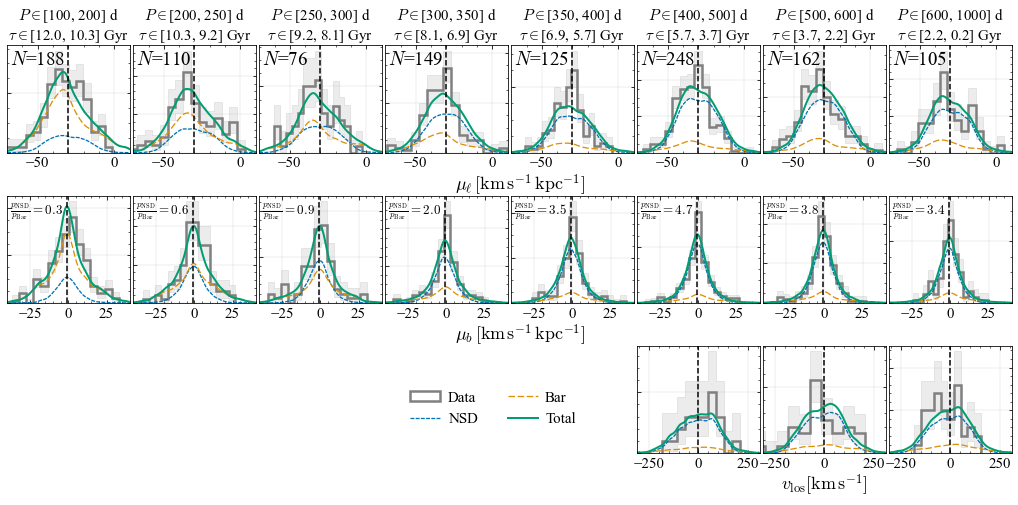

In [281]:
make_velocity_plot_grid(samples_map_justmub)

In [985]:
# don't go beyond here with Run All
assert False

AssertionError: 

In [ ]:
## ===================================
## Generate samples for MAP parameters
## ===================================
samples_map,lnL_map=generate_samples_emcee(aux_params, 
                                           min_results=min_results,
                                           Niterations=200, 
                                           data=data, add_errors=True)
samples_map_all,lnL_map_all=generate_samples_emcee(aux_params, 
                                           min_results=min_results,
                                           Niterations=200)

{'ln_Rdisk': -2.971700672587893, 'ln_Hdisk': -4.1766928495391715, 'ln_sigmaR0': 4.67705461735023, 'ln_RsigmaR': -1.3665098523242616}


/home/jls/miniconda3/envs/chemevo/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


{'ln_Rdisk': -2.971700672587893, 'ln_Hdisk': -4.1766928495391715, 'ln_sigmaR0': 4.67705461735023, 'ln_RsigmaR': -1.3665098523242616}


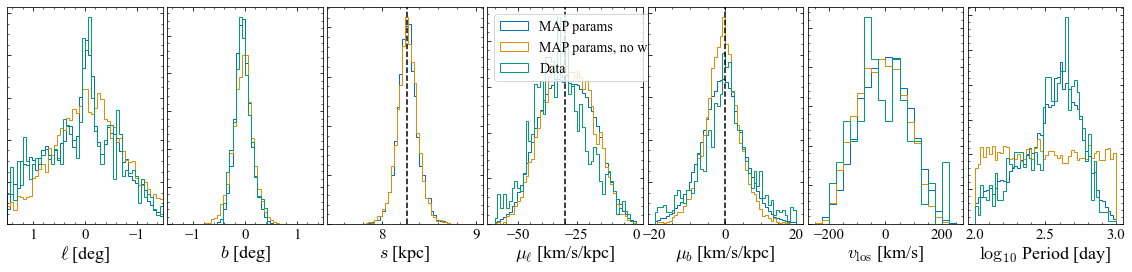

In [ ]:
from plotting_general import add_inner_ticks
f,a=plt.subplots(1,7,figsize=(20,4))
plt.subplots_adjust(wspace=0.03)
plt.sca(a[0])
plt.hist(np.rad2deg(samples_map[-100000:,0]),bins=50,histtype='step',range=[-1.5,1.5],density=True);
plt.hist(np.rad2deg(samples_map_all[-100000:,0]),bins=50,histtype='step',range=[-1.5,1.5],density=True);
# plt.hist(np.rad2deg(MC_m[-10000:,0]),bins=50,histtype='step',range=[-2,2],density=True);
# plt.hist(np.rad2deg(smp[:,0]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(data['l']-360.*(data['l']>180.),bins=50,histtype='step',range=[-1.5,1.5],density=True);
plt.xlabel(r'$\ell$ [deg]')
plt.gca().set_yticklabels([])
plt.xlim(-1.5,1.5)
plt.gca().invert_xaxis()
add_inner_ticks()
plt.sca(a[1])
plt.hist(np.rad2deg(samples_map[-100000:,1]),bins=50,histtype='step',range=[-1.5,1.5],density=True);
plt.hist(np.rad2deg(samples_map_all[-100000:,1]),bins=50,histtype='step',range=[-1.5,1.5],density=True);
# plt.hist(np.rad2deg(MC_m[-10000:,1]),bins=50,histtype='step',range=[-2,2],density=True);
# plt.hist(np.rad2deg(smp[:,1]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(data['b'],bins=50,histtype='step',range=[-1.5,1.5],density=True);
plt.xlabel(r'$b$ [deg]')
plt.gca().set_yticklabels([])
plt.xlim(-1.5,1.5)
add_inner_ticks()
plt.sca(a[2])
plt.hist(samples_map[-100000:,2],bins=50,histtype='step',range=[7.5,9.],density=True);
plt.hist(samples_map_all[-100000:,2],bins=50,histtype='step',range=[7.5,9.],density=True);
# plt.hist(MC_m[-10000:,2],bins=50,histtype='step',range=[7.5,9.]);
# plt.hist(smp[:,2],bins=50,histtype='step',range=[7.5,9.]);
plt.xlabel(r'$s$ [kpc]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.axvline(8.275, color='k', linestyle='--')
plt.sca(a[3])
plt.hist(samples_map[-100000:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='MAP params');
plt.hist(samples_map_all[-100000:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='MAP params, no weights');
# plt.hist(MC_m[-10000:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='Model');
# plt.hist(smp[:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='Sormani+22');
plt.hist(data['pml'],bins=50,histtype='step',range=[-60.,0.],density=True,label='Data');
plt.xlabel(r'$\mu_\ell$ [km/s/kpc]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.axvline(-6.411*4.74, color='k', linestyle='--')
plt.legend(loc='upper left')
plt.sca(a[4])
plt.hist(samples_map[-100000:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.hist(samples_map_all[-100000:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
# plt.hist(MC_m[-10000:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
# plt.hist(smp[:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.hist(data['pmb'],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.xlabel(r'$\mu_b$ [km/s/kpc]')
plt.axvline(-7.25/4.74/8.275, color='k', linestyle='--')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.sca(a[5])
plt.hist(samples_map[-100000:,5],bins=20,histtype='step',range=[-250.,250.],density=True);
plt.hist(samples_map_all[-100000:,5],bins=20,histtype='step',range=[-250.,250.],density=True);
# plt.hist(MC_m[-10000:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
# plt.hist(smp[:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
plt.hist(data['maser_OH_rv'],bins=20,histtype='step',range=[-250.,250.],density=True);
plt.xlabel(r'$v_\mathrm{los}$ [km/s]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.sca(a[6])
plt.hist(samples_map[-100000:,6],bins=50,histtype='step',range=[2,3],density=True);
plt.hist(samples_map_all[-100000:,6],bins=50,histtype='step',range=[2,3],density=True);
# plt.hist(MC_m[-10000:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
# plt.hist(smp[:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
plt.hist(np.log10(data['period'].values),bins=50,histtype='step',range=[2.,3.],density=True);
plt.xlabel(r'$\log_{10}$ Period [day]')
plt.gca().set_yticklabels([])
add_inner_ticks()

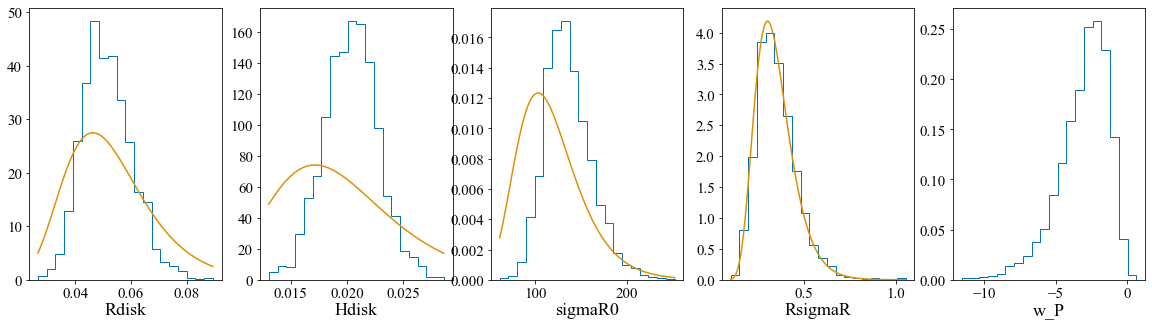

In [ ]:
f,a=plt.subplots(1,5,figsize=(20,5))
model = MCT[0]
for i,k in enumerate(['ln_Rdisk', 'ln_Hdisk', 'ln_sigmaR0', 'ln_RsigmaR', 'ln_w_P']):
    plt.sca(a[i])
    if i<4:
        n,b,p=plt.hist(np.exp(np.array(model.samples()[k])),bins=20,histtype='step',density=True);
    else:
        n,b,p=plt.hist(np.array(model.samples()[k]),bins=20,histtype='step',density=True);

    # plot log gaussian at min_results_s22.x[0] with scale 0.3
    x = np.linspace(b[0],b[-1],100)
    if i<4:
        plt.plot(x, np.exp(-0.5*(np.log(x)-min_results_s22.x[i])**2/0.3**2)/x/0.3/np.sqrt(2.*np.pi))
    plt.xlabel(k[3:])


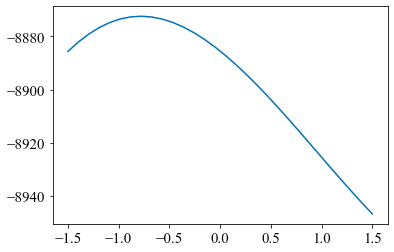

In [ ]:
import matplotlib.pyplot as plt
xxx = jnp.linspace(-1.5,1.5,30)
plt.plot(xxx, [jnp.sum(logL_numpyro(n_d_samples, {'ln_Rdisk_coeffs':aux_params['ln_Rdisk_guess']+jnp.zeros(Nknots),
                'ln_Hdisk_coeffs':aux_params['ln_Hdisk_guess']+x+jnp.zeros(Nknots),
                'ln_deltaR_coeffs':aux_params['ln_deltaR_guess']+jnp.zeros(Nknots),
                'ln_w_P_coeffs':jnp.zeros(Nknots)+min_results.x[3]}, aux_params)) for x in xxx])

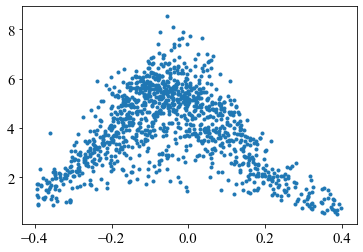

In [ ]:
pp = (data['period'].values>50.)
plt.plot(flip(data['b'].values,deg=True)[pp], np.exp(logsumexp(lMC_m.reshape(100,len(data)),axis=0)[pp]), '.')

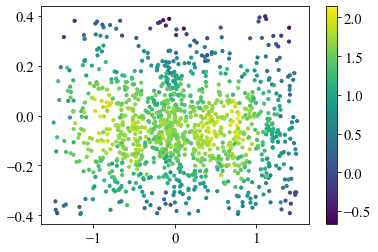

In [ ]:
from scipy.special import logsumexp
pp = (data['period'].values>50.)
plt.scatter(flip(data['l'].values,deg=True)[pp], data['b'].values[pp], 
            c=logsumexp(lMC_m.reshape(100,len(data)),axis=0)[pp],s=10)
plt.colorbar()

In [ ]:
aux_params = {'aux_knots':jnp.linspace(2.,3.,8), 'vO':140., 'Jv0':0., 'Jd0':0., 
              'include_portail_weight':True, 
              'ln_Rdisk_guess':min_results.x[0], 'ln_Hdisk_guess': min_results.x[1], 'ln_deltaR_guess':min_results.x[2]}

MC_m,lMC_m=generate_samples_emcee(aux_params, 
                                  model=model, 
                                  # min_results=min_results,
                                  Niterations=200, data=data, add_errors=True)

{'ln_Hdisk_coeffs': array([-3.88753371, -2.69341824, -2.81089158, -4.66705029, -3.60821899,
       -4.89348397, -4.63616889, -3.56044097]), 'ln_Rdisk_coeffs': array([-3.06025445, -2.34425887, -3.06278339, -2.90150157, -4.10645519,
       -2.48306534, -3.67419917, -3.8077352 ]), 'ln_deltaR_coeffs': array([-2.13628175, -1.83929611, -1.74504931, -2.35544679, -2.25017598,
       -3.11065447, -3.4523969 , -2.62770999]), 'ln_w_P_coeffs': array([-2.99590969,  5.59059483, -1.75017744,  2.09181249, -1.44514092,
       -0.43716418, -0.86178598,  0.3094826 ])}


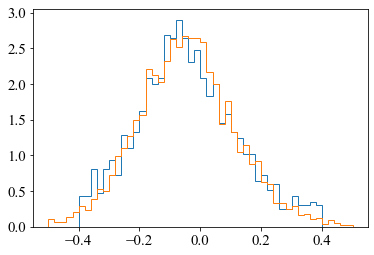

In [ ]:
plt.hist(data['b'].values,bins=50,histtype='step',range=[-.5,.5],density=True);
plt.hist(np.rad2deg(MC_m[-10000:,1]),bins=50,histtype='step',range=[-.5,.5],density=True);

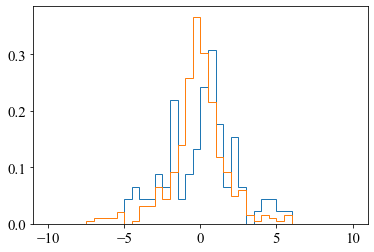

In [ ]:
# plt.hist(MC_m[-10000:,4][MC_m[-10000:,-1]>np.log10(600.)],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.hist(data['pmb'].values[(data['period'].values<150.)]/4.74,bins=40,histtype='step',range=[-10,10.],density=True);
plt.hist(data['pmb'].values[(data['period'].values>450.)&(data['period'].values<1000.)]/4.74,bins=40,histtype='step',range=[-10,10.],density=True);

# plt.hist(MC_m[-10000:,4][MC_m[-10000:,-1]<np.log10(300.)],bins=50,histtype='step',range=[-20.,20.],density=True);


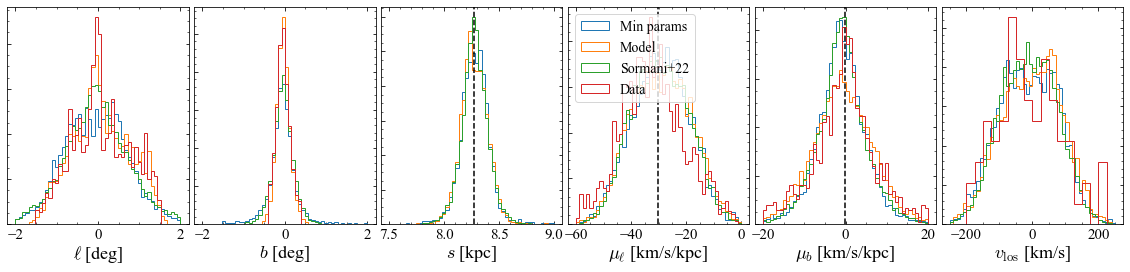

In [ ]:
from plotting_general import add_inner_ticks
f,a=plt.subplots(1,6,figsize=(20,4))
plt.subplots_adjust(wspace=0.03)
plt.sca(a[0])
plt.hist(np.rad2deg(MC[-10000:,0]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(np.rad2deg(MC_m[-10000:,0]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(np.rad2deg(smp[:,0]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(data['l']-360.*(data['l']>180.),bins=50,histtype='step',range=[-2.,2.],density=True);
plt.xlabel(r'$\ell$ [deg]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.sca(a[1])
plt.hist(np.rad2deg(MC[-10000:,1]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(np.rad2deg(MC_m[-10000:,1]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(np.rad2deg(smp[:,1]),bins=50,histtype='step',range=[-2,2],density=True);
plt.hist(data['b'],bins=50,histtype='step',range=[-2.,2.],density=True);
plt.xlabel(r'$b$ [deg]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.sca(a[2])
plt.hist(MC[-10000:,2],bins=50,histtype='step',range=[7.5,9.]);
plt.hist(MC_m[-10000:,2],bins=50,histtype='step',range=[7.5,9.]);
plt.hist(smp[:,2],bins=50,histtype='step',range=[7.5,9.]);
plt.xlabel(r'$s$ [kpc]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.axvline(8.275, color='k', linestyle='--')
plt.sca(a[3])
plt.hist(MC[-10000:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='Min params');
plt.hist(MC_m[-10000:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='Model');
plt.hist(smp[:,3],bins=50,histtype='step',range=[-60.,0.],density=True,label='Sormani+22');
plt.hist(data['pml'],bins=50,histtype='step',range=[-60.,0.],density=True,label='Data');
plt.xlabel(r'$\mu_\ell$ [km/s/kpc]')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.axvline(-6.411*4.74, color='k', linestyle='--')
plt.legend(loc='upper left')
plt.sca(a[4])
plt.hist(MC[-10000:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.hist(MC_m[-10000:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.hist(smp[:,4],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.hist(data['pmb'],bins=50,histtype='step',range=[-20.,20.],density=True);
plt.xlabel(r'$\mu_b$ [km/s/kpc]')
plt.axvline(-7.25/4.74/8.275, color='k', linestyle='--')
plt.gca().set_yticklabels([])
add_inner_ticks()
plt.sca(a[5])
plt.hist(MC[-10000:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
plt.hist(MC_m[-10000:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
plt.hist(smp[:,5],bins=50,histtype='step',range=[-250.,250.],density=True);
plt.hist(data['maser_OH_rv'],bins=20,histtype='step',range=[-250.,250.],density=True);
plt.xlabel(r'$v_\mathrm{los}$ [km/s]')
plt.gca().set_yticklabels([])
add_inner_ticks()

In [ ]:
Nknots = 4

aux_params = {'aux_knots':jnp.linspace(2.,3.,Nknots), 'vO':140., 'Jv0':0., 'Jd0':0., 
              'include_portail_weight':True, 
              'ln_Rdisk_guess':jnp.log(0.075), 
              'ln_Hdisk_guess': jnp.log(0.025), 
              'ln_deltaR_guess':jnp.log(0.07)}


aux_params = {'aux_knots':jnp.linspace(2.,3.,Nknots), 'vO':140., 'Jv0':0., 'Jd0':0., 
              'include_portail_weight':True, 
              'ln_Rdisk_guess':min_results.x[0], 
              'ln_Hdisk_guess': min_results.x[1], 
              'ln_deltaR_guess':min_results.x[2]}
xxx = jnp.linspace(-1.5,1.5,30)
plt.plot(xxx, [jnp.sum(logL_numpyro(n_d_samples, {'ln_Rdisk_coeffs':aux_params['ln_Rdisk_guess']+jnp.zeros(Nknots),
                'ln_Hdisk_coeffs':aux_params['ln_Hdisk_guess']+x+jnp.zeros(Nknots),
                'ln_deltaR_coeffs':aux_params['ln_deltaR_guess']+jnp.zeros(Nknots),
                'ln_w_P_coeffs':jnp.zeros(Nknots)+min_results.x[3]}, aux_params)) for x in xxx])

NameError: name 'min_results' is not defined

NameError: name 'n_d_samples' is not defined

In [ ]:
Nknots = 8
aux_params = {'aux_knots':jnp.linspace(2.,3.,Nknots), 'vO':140., 'Jv0':0., 'Jd0':0., 
              'include_portail_weight':True, 
              'ln_Rdisk_guess':min_results.x[0], 'ln_Hdisk_guess': min_results.x[1], 'ln_deltaR_guess':min_results.x[2]}

# default_dist = numpyro.distributions.Normal(5.).expand([len(aux_params['aux_knots'])])
parameters = {'ln_Rdisk_coeffs':  numpyro.distributions.Normal(loc=aux_params['ln_Rdisk_guess'],scale=1.).expand([len(aux_params['aux_knots'])]), 
              'ln_Hdisk_coeffs':  numpyro.distributions.Normal(loc=aux_params['ln_Hdisk_guess'],scale=1.).expand([len(aux_params['aux_knots'])]), 
              'ln_deltaR_coeffs': numpyro.distributions.Normal(loc=aux_params['ln_deltaR_guess'],scale=1.).expand([len(aux_params['aux_knots'])]),
              'ln_w_P_coeffs':    numpyro.distributions.Normal(min_results.x[3],1.).expand([len(aux_params['aux_knots'])])
              }

model = numpyro_model(logL_numpyro, parameters, n_d_samples, aux_params)
model.run_mcmc(num_warmup=200, num_samples=200, num_chains=1)

warmup:  19%|████████▎                                   | 75/400 [17:21<1:36:42, 17.85s/it, 1023 steps of size 3.31e-03. acc. prob=0.75]

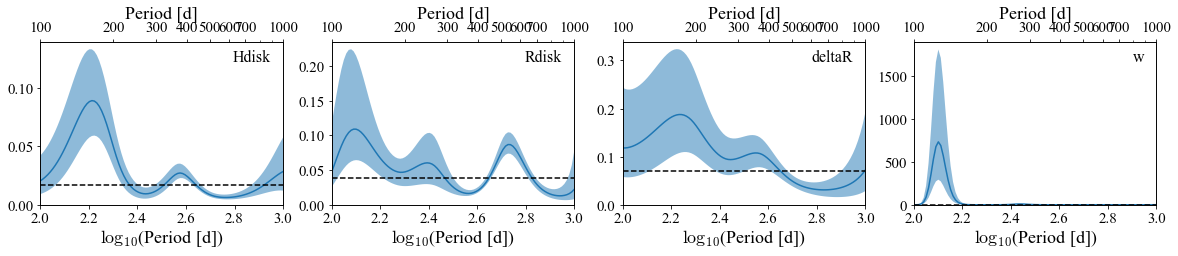

In [ ]:
f,a=plt.subplots(1,4,figsize=(20,3))
for i, k in enumerate(model.samples().keys()):
    plt.sca(a[i])
    test_spline = [InterpolatedUnivariateSpline(jnp.linspace(2.,3.,aux_params['aux_knots'].shape[0]), 
                                        np.nanpercentile(np.array(model.samples()[k]), x, axis=0), k=3) for x in [16,50,84]]
    plt.plot(xrr, np.exp(test_spline[1](xrr)), label='16')
    plt.fill_between(xrr,np.exp(test_spline[0](xrr)), np.exp(test_spline[2](xrr)), alpha=0.5)
    if i<3:
        plt.axhline(np.exp(aux_params[k[:-7]+'_guess']), color='k', ls='--')
    else:
        plt.axhline(1., color='k', ls='--')
    plt.annotate(k.split('_')[1], (0.95,0.95), xycoords='axes fraction', ha='right', va='top', fontsize=16)
    plt.ylim(0.,)
    plt.xlim(2.,3.)
    plt.xlabel(r'$\log_{10}$(Period [d])')
    # add secondary axis
    ax2 = plt.gca().twiny()
    ax2.set_xlim(10.**2., 10.**3.)
    ax2.set_xscale('log')
    ax2.set_xlabel('Period [d]')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.set_xticks([100,200,300,400,500,600,700,1000])
    ax2.set_xticklabels([100,200,300,400,500,600,700,1000])
# plt.ylim(0.,)

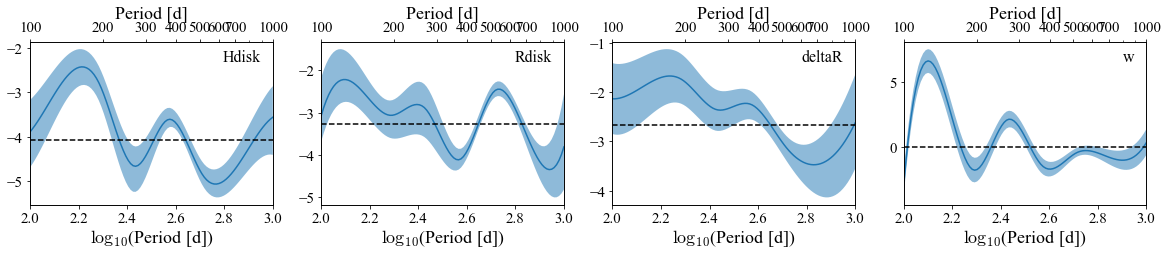

In [ ]:
f,a=plt.subplots(1,4,figsize=(20,3))
for i, k in enumerate(model.samples().keys()):
    plt.sca(a[i])
    test_spline = [InterpolatedUnivariateSpline(jnp.linspace(2.,3.,aux_params['aux_knots'].shape[0]), 
                                        np.nanpercentile(np.array(model.samples()[k]), x, axis=0), k=3) for x in [16,50,84]]
    plt.plot(xrr, test_spline[1](xrr), label='16')
    plt.fill_between(xrr,test_spline[0](xrr), test_spline[2](xrr), alpha=0.5)
    if i<3:
        plt.axhline(aux_params[k[:-7]+'_guess'], color='k', ls='--')
    else:
        plt.axhline(0., color='k', ls='--')
    plt.annotate(k.split('_')[1], (0.95,0.95), xycoords='axes fraction', ha='right', va='top', fontsize=16)
    plt.xlim(2.,3.)
    plt.xlabel(r'$\log_{10}$(Period [d])')
    # add secondary axis
    ax2 = plt.gca().twiny()
    ax2.set_xlim(10.**2., 10.**3.)
    ax2.set_xscale('log')
    ax2.set_xlabel('Period [d]')
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.set_xticks([100,200,300,400,500,600,700,1000])
    ax2.set_xticklabels([100,200,300,400,500,600,700,1000])
# plt.ylim(0.,)

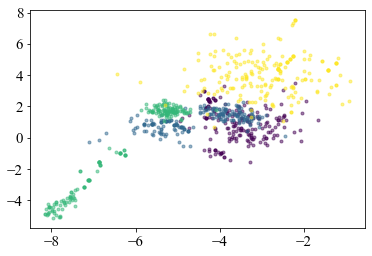

In [ ]:
for i in range(aux_params['aux_knots'].shape[0]):
    # plt.plot(model.samples()['ln_Rdisk_coeffs'][:,i], model.samples()['ln_Hdisk_coeffs'][:,i], 'k.', alpha=0.1)
    plt.plot(model.samples()['ln_Hdisk_coeffs'][:,i], model.samples()['ln_w_P_coeffs'][:,i], '.', c=plt.cm.viridis(i/(aux_params['aux_knots'].shape[0]-1)), alpha=0.5)

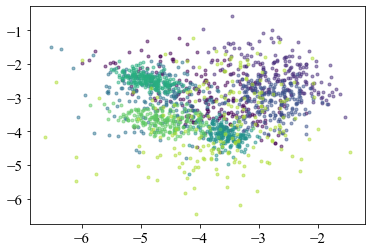

In [ ]:
for i in range(aux_params['aux_knots'].shape[0]):
    # plt.plot(model.samples()['ln_Rdisk_coeffs'][:,i], model.samples()['ln_Hdisk_coeffs'][:,i], 'k.', alpha=0.1)
    plt.plot(model.samples()['ln_Hdisk_coeffs'][:,i], model.samples()['ln_Rdisk_coeffs'][:,i], '.', c=plt.cm.viridis(i/aux_params['aux_knots'].shape[0]), alpha=0.5)

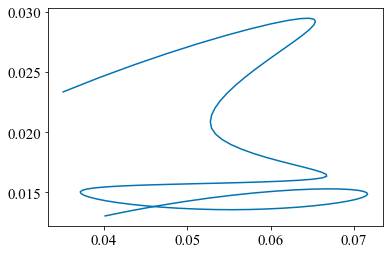

In [ ]:
test_spline = InterpolatedUnivariateSpline(jnp.linspace(2.,3.,mc.aux_parameters['aux_knots'].shape[0]), 
                                        np.nanpercentile(np.array(mc.samples()['ln_Rdisk']), 50., axis=0), k=3)
test_spline2 = InterpolatedUnivariateSpline(jnp.linspace(2.,3.,mc.aux_parameters['aux_knots'].shape[0]), 
                                        np.nanpercentile(np.array(mc.samples()['ln_Hdisk']), 50., axis=0), k=3)
                                        
plt.plot(np.exp(test_spline(xrr)), np.exp(test_spline2(xrr)))